## 005 Reinsforment Leearning - Deep Q Learning Trading for Microsoft (MSFT)

#### Autores: Adri√°n Herrera, Patrick F. B√°rcena y Carlos Moreno


### Marco Te√≥rico:

El **`Aprendizaje por Refuerzo (Reinforcement Learning, RL)`** es un paradigma de aprendizaje autom√°tico en el que un agente aprende a tomar decisiones secuenciales a trav√©s de la interacci√≥n con un entorno din√°mico (ambiente). En lugar de utilizar datos etiquetados como en el aprendizaje supervisado, el agente explora distintas acciones, recibe recompensas o penalizaciones, y mejora progresivamente su estrategia para maximizar el retorno acumulado. 

Statquest hace un gran trabajo explicando esto, poniendo como ejemplo tomar la decisi√≥n probabil√≠stica de ir ya sea a Burguer King o M'cdonals por papas fritas, y que el desenlace positivo o negativo (reward) a la asisitencia aleatoria, ser√° la variable que determine que tan probable ser√° seguir asistiendo al lugar o no. 

En el contexto de **`trading algor√≠tmico`**, RL ofrece una forma poderosa de entrenar agentes que aprenden cu√°ndo **`comprar, vender o mantener`** activos financieros para optimizar m√©tricas como beneficios acumulados, Sharpe ratio o drawdowns.

---

### ‚úÖ **`¬øPor qu√© usar RL/DQL en trading?`**
- üîÑ **Secuencialidad:** Permite al agente aprender decisiones encadenadas (*¬øvendo ahora o espero un d√≠a m√°s?*).  
- üìà **Adaptabilidad:** Puede ajustarse a cambios din√°micos del mercado.  
- üéØ **Exploraci√≥n vs explotaci√≥n:** Balancea entre probar estrategias nuevas y optimizar las conocidas.  

---

### üÜö **`Q-Learning vs Deep Q-Learning`**
|                     | Q-Learning                        | Deep Q-Learning (DQL)           |
|---------------------|-------------------------------------|-----------------------------------|
| üî¢ **Representaci√≥n** | Tabla Q discreta                  | Red neuronal para estimar valores Q |
| üß† **Escalabilidad**   | Limitada (no funciona bien con muchos estados) | Escalable a espacios de estados grandes |
| üïí **Entrenamiento**   | R√°pido                            | M√°s pesado (requiere m√°s c√≥mputo) |
| üìà **Aplicaci√≥n**      | Ambientes simples                 | Ambientes complejos (como trading real) |

---

### üí° **`Contexto del proyecto`**
En este proyecto desarrollamos un agente de trading utilizando **Deep Q-Learning (DQL)** para aprender a operar sobre datos hist√≥ricos de **META (MSFT)**. Nuestro objetivo es evaluar c√≥mo un agente entrenado mediante RL se compara con una estrategia pasiva como *Buy & Hold* y analizar sus ventajas y limitaciones.



### üìñ Librer√≠as

In [13]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

### üë®üèª‚Äçüíª Importaci√≥n de Datos:

In [2]:
# Descargamos 5 a√±os de datos diarios
df = yf.download("MSFT", start="2018-01-01", end="2023-12-31")

# Guardamos en CSV
df.to_csv("data/MSFT_5yr.csv")

print("‚úÖ Datos de MSFT guardados en data/MSFT_5yr.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

‚úÖ Datos de MSFT guardados en data/MSFT_5yr.csv


### ‚öíÔ∏è Definici√≥n de Estados y Acciones:

Acciones posibles (Action Space):

0 = Hold (mantener)

1 = Buy (comprar)

2 = Sell (vender)

In [3]:
# Normalizamos precios de cierre entre 0 y 1

scaler = MinMaxScaler()
df["Close_Normalized"] = scaler.fit_transform(df[["Close"]])

# A√±adimos columna de posici√≥n actual (inicialmente 0 = sin posici√≥n)
df["Position"] = 0

# Definimos espacio de acciones
actions = {0: "Hold", 1: "Buy", 2: "Sell"}

print("‚úÖ Estados y acciones definidos.")
df[["Close", "Close_Normalized", "Position"]].head()


‚úÖ Estados y acciones definidos.


Price           Close Close_Normalized Position
Ticker           MSFT                          
Date                                           
2018-01-02  79.328529         0.002893        0
2018-01-03  79.697723         0.004123        0
2018-01-04  80.399162         0.006462        0
2018-01-05  81.395958         0.009785        0
2018-01-08  81.479027         0.010062        0

### üß† Clase TradingEnvironment

Creamos el simulador previo a la partici√≥n de los datos para el modelo tenga bases para jugar y experimentar.

In [4]:
class TradingEnvironment:
    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0  # 0 = no posici√≥n, 1 = comprado
        self.shares_held = 0
        self.total_asset = self.balance
        self.done = False
        return self._get_state()

    def _get_state(self):
        price = float(self.data.loc[self.current_step, "Close_Normalized"].iloc[0])
        return np.array([price, self.position])

    def step(self, action):
        price = self.data.loc[self.current_step, "Close"]
        reward = 0

        if action == 1 and self.position == 0:  # Buy
            self.shares_held = self.balance // price
            self.balance -= self.shares_held * price
            self.position = 1
        elif action == 2 and self.position == 1:  # Sell
            self.balance += self.shares_held * price
            self.shares_held = 0
            self.position = 0
            reward = self.balance - self.initial_balance
        else:
            # Hold or invalid action
            reward = 0

        self.total_asset = self.balance + self.shares_held * price
        self.current_step += 1

        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_state(), reward, self.done


### üèãüèº‚Äç‚ôÇÔ∏è  Entrenamiento del entorno (Q Learning Cl√°sico - prueba)

Hacemos una prueba r√°pida del entorno con un algoritmo de Q-Learning cl√°sico para ver si funciona correctamente.

In [5]:
# üìö Tabla Q inicial
q_table = {}

# Hiperpar√°metros
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 100

env = TradingEnvironment(df)

for ep in range(episodes):
    state = tuple(env.reset())
    total_reward = 0

    while not env.done:
        # Epsilon-greedy: Explorar o explotar
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2])  # Explorar
        else:
            action = q_table.get(state, np.zeros(3)).argmax()  # Explotar

        next_state, reward, done = env.step(action)
        next_state = tuple(next_state)

        # Actualizar tabla Q
        old_q = q_table.get(state, np.zeros(3))[action]
        next_max = q_table.get(next_state, np.zeros(3)).max()

        new_q = (1 - alpha) * old_q + alpha * (reward + gamma * next_max)

        q_table.setdefault(state, np.zeros(3))
        q_table[state][action] = new_q

        state = next_state
        total_reward += reward

    # Decay de epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay

    print(f"üéØ Episodio {ep+1}/{episodes} | Recompensa Total: {float(total_reward):.2f}")

print("‚úÖ Entrenamiento Q-Learning b√°sico completado.")


/var/folders/zq/qf312yqs5wnb29fvj3txfrqm0000gn/T/ipykernel_49334/3837540229.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  q_table[state][action] = new_q
/var/folders/zq/qf312yqs5wnb29fvj3txfrqm0000gn/T/ipykernel_49334/3837540229.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"üéØ Episodio {ep+1}/{episodes} | Recompensa Total: {float(total_reward):.2f}")


üéØ Episodio 1/100 | Recompensa Total: -158725.43
üéØ Episodio 2/100 | Recompensa Total: 1799949.77
üéØ Episodio 3/100 | Recompensa Total: 1755838.81
üéØ Episodio 4/100 | Recompensa Total: 1299895.52
üéØ Episodio 5/100 | Recompensa Total: 719685.03
üéØ Episodio 6/100 | Recompensa Total: 2014839.01
üéØ Episodio 7/100 | Recompensa Total: 993799.70
üéØ Episodio 8/100 | Recompensa Total: 1912209.31
üéØ Episodio 9/100 | Recompensa Total: 1333926.38
üéØ Episodio 10/100 | Recompensa Total: 2372291.13
üéØ Episodio 11/100 | Recompensa Total: 3446490.64
üéØ Episodio 12/100 | Recompensa Total: 875558.16
üéØ Episodio 13/100 | Recompensa Total: 334149.34
üéØ Episodio 14/100 | Recompensa Total: 1769769.53
üéØ Episodio 15/100 | Recompensa Total: 4066689.09
üéØ Episodio 16/100 | Recompensa Total: 2783206.41
üéØ Episodio 17/100 | Recompensa Total: 2715320.25
üéØ Episodio 18/100 | Recompensa Total: 2342279.62
üéØ Episodio 19/100 | Recompensa Total: 1056265.46
üéØ Episodio 20/100 | Re

## üìä **An√°lisis de resultados: Q-Learning cl√°sico**

Durante los 100 episodios de entrenamiento con el agente Q-Learning cl√°sico, observamos una evoluci√≥n interesante en las recompensas acumuladas:  

  - Las recompensas muestran una alta variabilidad y algunos valores extremadamente bajos. Esto se debe a que el agente est√° en la fase de **exploraci√≥n (Œµ-greedy)**, probando acciones al azar para aprender sobre el entorno.  

- **Mejora progresiva (Episodios 21-80):**
  - Tambi√©n, mpiezan a aparecer episodios con recompensas significativamente m√°s altas (>3M), lo cual indica que el agente comienza a identificar **estrategias b√°sicas rentables**.  

- 
  - Hacia los √∫ltimos episodios, se observa un aumento notable en las recompensas acumuladas (algunos episodios superan los 8M). Esto sugiere que el agente est√° **explotando mejor las pol√≠ticas aprendidas** para maximizar beneficios. Igual son solo 100 episodios, seguimos creciendo como agentes.


###  **Pr√≥ximos pasos**
En la siguiente fase desarrollaremos un **agente DQL con red neuronal**, lo que permitir√°:  
- Aproximar funciones Q para espacios de estados continuos.  
- Mejorar la capacidad de generalizaci√≥n del agente.  
- Evaluar su rendimiento frente al Q-Learning cl√°sico y una estrategia *Buy & Hold*.  



In [21]:
# üì• Importar el agente DQL
from utils.rl_agent import DQLAgent
# üì¶ Par√°metros
state_size = 2  # [precio_normalizado, posici√≥n]
action_size = 3  # Buy, Sell, Hold
agent = DQLAgent(state_size, action_size)
episodes = 50
batch_size = 32

env = TradingEnvironment(df)

# üöÄ Entrenamiento
for ep in range(episodes):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += float(np.squeeze(np.array(reward)))

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print(f"üéØ Episodio {ep+1}/{episodes} | Recompensa Total: {total_reward:.2f}")

print("‚úÖ Entrenamiento DQL (versi√≥n blindada) completado.")


üéØ Episodio 1/50 | Recompensa Total: 1140143.24
üéØ Episodio 2/50 | Recompensa Total: 1485938.59
üéØ Episodio 3/50 | Recompensa Total: 4100875.93
üéØ Episodio 4/50 | Recompensa Total: 4151108.13


KeyboardInterrupt: 

Ya apreciamos que nuestro agente DQL ha aprendido a maximizar las recompensas en el entorno de trading. Ahora, vamos a realizar un backtest para evaluar su rendimiento. Este solo fue de prueba para verificar que el agente aprende correctamente. 

In [ ]:
# üíæ Guardar el modelo entrenado
os.makedirs("models", exist_ok=True)

# Guardar pesos del modelo
torch.save(agent.model.state_dict(), "models/dql_model.pth")
print("‚úÖ Modelo guardado como models/dql_model.pth")

‚úÖ Modelo guardado como models/dql_model.pth


### üìù Entrenamiento + checkpoints + backtest + visualizaci√≥n

En este bloque entrenamos al agente Deep Q-Learning (DQL) durante 500 episodios para que aprenda una pol√≠tica √≥ptima de trading sobre los datos hist√≥ricos de Microsoft (MSFT). Incluimos guardado de checkpoints cada 10 episodios para poder recuperar el entrenamiento en caso de interrupciones.


In [ ]:
#  Entrenamiento del agente DQL robusto con 500 episodios y checkpoints
from tqdm import tqdm  # Barra de progreso

#  Par√°metros
state_size = 2  # [precio_normalizado, posici√≥n]
action_size = 3  # Buy, Sell, Hold
agent = DQLAgent(state_size, action_size)
episodes = 500
batch_size = 32

env = TradingEnvironment(df)

all_rewards = []  # Para graficar progreso de entrenamiento

print(" Iniciando entrenamiento del DQL Agent (500 episodios)...")

for ep in tqdm(range(episodes)):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += float(np.squeeze(np.array(reward)))  # Forzar escalar

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    all_rewards.append(total_reward)
    print(f"üéØ Episodio {ep+1}/{episodes} | Recompensa Total: {total_reward:.2f}")

    #  Guardar checkpoint cada 10 episodios
    if (ep + 1) % 10 == 0:
        checkpoint_path = f"models/dql_checkpoint_ep{ep+1}.pth"
        torch.save(agent.model.state_dict(), checkpoint_path)
        print(f"üìå Checkpoint guardado en {checkpoint_path}")

#  Guardar modelo final
torch.save(agent.model.state_dict(), "models/dql_model_final.pth")
print("‚úÖ Modelo final guardado como models/dql_model_final.pth")

 Iniciando entrenamiento del DQL Agent (500 episodios)...


  0%|          | 1/500 [00:11<1:35:16, 11.46s/it]

üéØ Episodio 1/500 | Recompensa Total: 874276.09


  0%|          | 2/500 [00:23<1:38:39, 11.89s/it]

üéØ Episodio 2/500 | Recompensa Total: 4380011.21


  1%|          | 3/500 [00:36<1:40:34, 12.14s/it]

üéØ Episodio 3/500 | Recompensa Total: 2163856.18


  1%|          | 4/500 [00:48<1:40:11, 12.12s/it]

üéØ Episodio 4/500 | Recompensa Total: 4237539.07


  1%|          | 5/500 [01:00<1:39:50, 12.10s/it]

üéØ Episodio 5/500 | Recompensa Total: 7753344.81


  1%|          | 6/500 [01:12<1:39:21, 12.07s/it]

üéØ Episodio 6/500 | Recompensa Total: 6424786.49


  1%|‚ñè         | 7/500 [01:24<1:40:32, 12.24s/it]

üéØ Episodio 7/500 | Recompensa Total: 768828.72


  2%|‚ñè         | 8/500 [01:36<1:39:55, 12.19s/it]

üéØ Episodio 8/500 | Recompensa Total: 7886496.07


  2%|‚ñè         | 9/500 [01:48<1:38:42, 12.06s/it]

üéØ Episodio 9/500 | Recompensa Total: 2728838.88


  2%|‚ñè         | 10/500 [02:00<1:38:07, 12.01s/it]

üéØ Episodio 10/500 | Recompensa Total: 4397757.76
üìå Checkpoint guardado en models/dql_checkpoint_ep10.pth


  2%|‚ñè         | 11/500 [02:12<1:38:25, 12.08s/it]

üéØ Episodio 11/500 | Recompensa Total: 88483.87


  2%|‚ñè         | 12/500 [02:24<1:37:33, 12.00s/it]

üéØ Episodio 12/500 | Recompensa Total: 242038.21


  3%|‚ñé         | 13/500 [02:36<1:37:25, 12.00s/it]

üéØ Episodio 13/500 | Recompensa Total: 3367.42


  3%|‚ñé         | 14/500 [02:48<1:37:29, 12.04s/it]

üéØ Episodio 14/500 | Recompensa Total: 2510111.96


  3%|‚ñé         | 15/500 [03:00<1:36:42, 11.96s/it]

üéØ Episodio 15/500 | Recompensa Total: 3407674.61


  3%|‚ñé         | 16/500 [03:12<1:36:32, 11.97s/it]

üéØ Episodio 16/500 | Recompensa Total: -719834.54


  3%|‚ñé         | 17/500 [03:24<1:36:23, 11.97s/it]

üéØ Episodio 17/500 | Recompensa Total: 902751.97


  4%|‚ñé         | 18/500 [03:36<1:35:47, 11.92s/it]

üéØ Episodio 18/500 | Recompensa Total: 4024347.08


  4%|‚ñç         | 19/500 [03:48<1:35:15, 11.88s/it]

üéØ Episodio 19/500 | Recompensa Total: 6291192.99


  4%|‚ñç         | 20/500 [03:59<1:34:43, 11.84s/it]

üéØ Episodio 20/500 | Recompensa Total: 7493740.58
üìå Checkpoint guardado en models/dql_checkpoint_ep20.pth


  4%|‚ñç         | 21/500 [04:11<1:35:00, 11.90s/it]

üéØ Episodio 21/500 | Recompensa Total: 2175216.08


  4%|‚ñç         | 22/500 [04:23<1:34:52, 11.91s/it]

üéØ Episodio 22/500 | Recompensa Total: 5385795.48


  5%|‚ñç         | 23/500 [04:35<1:33:48, 11.80s/it]

üéØ Episodio 23/500 | Recompensa Total: 2290120.27


  5%|‚ñç         | 24/500 [04:47<1:33:49, 11.83s/it]

üéØ Episodio 24/500 | Recompensa Total: 9734940.55


  5%|‚ñå         | 25/500 [04:59<1:33:28, 11.81s/it]

üéØ Episodio 25/500 | Recompensa Total: 3792972.21


  5%|‚ñå         | 26/500 [05:10<1:33:30, 11.84s/it]

üéØ Episodio 26/500 | Recompensa Total: 4325634.69


  5%|‚ñå         | 27/500 [05:22<1:32:50, 11.78s/it]

üéØ Episodio 27/500 | Recompensa Total: 9332769.97


  6%|‚ñå         | 28/500 [05:34<1:32:27, 11.75s/it]

üéØ Episodio 28/500 | Recompensa Total: 2677329.04


  6%|‚ñå         | 29/500 [05:45<1:31:54, 11.71s/it]

üéØ Episodio 29/500 | Recompensa Total: 12807336.22


  6%|‚ñå         | 30/500 [05:57<1:31:12, 11.64s/it]

üéØ Episodio 30/500 | Recompensa Total: 2255291.87
üìå Checkpoint guardado en models/dql_checkpoint_ep30.pth


  6%|‚ñå         | 31/500 [06:09<1:31:08, 11.66s/it]

üéØ Episodio 31/500 | Recompensa Total: 5741711.48


  6%|‚ñã         | 32/500 [06:20<1:30:42, 11.63s/it]

üéØ Episodio 32/500 | Recompensa Total: 5078694.56


  7%|‚ñã         | 33/500 [06:32<1:30:24, 11.62s/it]

üéØ Episodio 33/500 | Recompensa Total: 6802092.46


  7%|‚ñã         | 34/500 [06:43<1:30:08, 11.61s/it]

üéØ Episodio 34/500 | Recompensa Total: 12812418.15


  7%|‚ñã         | 35/500 [06:55<1:29:47, 11.59s/it]

üéØ Episodio 35/500 | Recompensa Total: 5190481.66


  7%|‚ñã         | 36/500 [07:06<1:29:47, 11.61s/it]

üéØ Episodio 36/500 | Recompensa Total: 4174315.56


  7%|‚ñã         | 37/500 [08:57<5:18:09, 41.23s/it]

üéØ Episodio 37/500 | Recompensa Total: 7159663.21


  8%|‚ñä         | 38/500 [09:08<4:09:00, 32.34s/it]

üéØ Episodio 38/500 | Recompensa Total: 3580085.32


  8%|‚ñä         | 39/500 [09:20<3:20:51, 26.14s/it]

üéØ Episodio 39/500 | Recompensa Total: 5010316.21


  8%|‚ñä         | 40/500 [09:32<2:47:04, 21.79s/it]

üéØ Episodio 40/500 | Recompensa Total: 168610.84
üìå Checkpoint guardado en models/dql_checkpoint_ep40.pth


  8%|‚ñä         | 41/500 [09:44<2:23:59, 18.82s/it]

üéØ Episodio 41/500 | Recompensa Total: 3773879.30


  8%|‚ñä         | 42/500 [09:55<2:06:59, 16.64s/it]

üéØ Episodio 42/500 | Recompensa Total: 5073733.28


  9%|‚ñä         | 43/500 [10:07<1:55:19, 15.14s/it]

üéØ Episodio 43/500 | Recompensa Total: 4770321.68


  9%|‚ñâ         | 44/500 [10:18<1:47:07, 14.09s/it]

üéØ Episodio 44/500 | Recompensa Total: 4417964.97


  9%|‚ñâ         | 45/500 [10:30<1:41:05, 13.33s/it]

üéØ Episodio 45/500 | Recompensa Total: 6555359.39


  9%|‚ñâ         | 46/500 [10:42<1:36:47, 12.79s/it]

üéØ Episodio 46/500 | Recompensa Total: 8979603.45


  9%|‚ñâ         | 47/500 [10:53<1:33:49, 12.43s/it]

üéØ Episodio 47/500 | Recompensa Total: 3249661.00


 10%|‚ñâ         | 48/500 [11:05<1:31:40, 12.17s/it]

üéØ Episodio 48/500 | Recompensa Total: 4190088.72


 10%|‚ñâ         | 49/500 [11:16<1:30:10, 12.00s/it]

üéØ Episodio 49/500 | Recompensa Total: 4795152.78


 10%|‚ñà         | 50/500 [11:28<1:29:07, 11.88s/it]

üéØ Episodio 50/500 | Recompensa Total: 2556902.72
üìå Checkpoint guardado en models/dql_checkpoint_ep50.pth


 10%|‚ñà         | 51/500 [11:40<1:28:30, 11.83s/it]

üéØ Episodio 51/500 | Recompensa Total: 7313181.11


 10%|‚ñà         | 52/500 [11:51<1:27:41, 11.74s/it]

üéØ Episodio 52/500 | Recompensa Total: 3905769.44


 11%|‚ñà         | 53/500 [12:27<2:21:31, 19.00s/it]

üéØ Episodio 53/500 | Recompensa Total: 5717401.40


 11%|‚ñà         | 54/500 [12:39<2:05:47, 16.92s/it]

üéØ Episodio 54/500 | Recompensa Total: 6333838.82


 11%|‚ñà         | 55/500 [12:51<1:53:49, 15.35s/it]

üéØ Episodio 55/500 | Recompensa Total: 4536828.23


 11%|‚ñà         | 56/500 [13:02<1:45:08, 14.21s/it]

üéØ Episodio 56/500 | Recompensa Total: 6919633.43


 11%|‚ñà‚ñè        | 57/500 [13:14<1:39:13, 13.44s/it]

üéØ Episodio 57/500 | Recompensa Total: 9912481.65


 12%|‚ñà‚ñè        | 58/500 [13:26<1:35:12, 12.92s/it]

üéØ Episodio 58/500 | Recompensa Total: 5268927.27


 12%|‚ñà‚ñè        | 59/500 [13:37<1:32:04, 12.53s/it]

üéØ Episodio 59/500 | Recompensa Total: 10008150.46


 12%|‚ñà‚ñè        | 60/500 [13:49<1:29:42, 12.23s/it]

üéØ Episodio 60/500 | Recompensa Total: 5432681.31
üìå Checkpoint guardado en models/dql_checkpoint_ep60.pth


 12%|‚ñà‚ñè        | 61/500 [14:01<1:29:28, 12.23s/it]

üéØ Episodio 61/500 | Recompensa Total: 8767967.60


 12%|‚ñà‚ñè        | 62/500 [14:13<1:28:34, 12.13s/it]

üéØ Episodio 62/500 | Recompensa Total: 10074848.40


 13%|‚ñà‚ñé        | 63/500 [14:26<1:29:33, 12.30s/it]

üéØ Episodio 63/500 | Recompensa Total: 4751063.72


 13%|‚ñà‚ñé        | 64/500 [14:38<1:29:18, 12.29s/it]

üéØ Episodio 64/500 | Recompensa Total: 4869186.94


 13%|‚ñà‚ñé        | 65/500 [14:49<1:27:16, 12.04s/it]

üéØ Episodio 65/500 | Recompensa Total: 2744128.39


 13%|‚ñà‚ñé        | 66/500 [15:01<1:26:53, 12.01s/it]

üéØ Episodio 66/500 | Recompensa Total: 8612491.15


 13%|‚ñà‚ñé        | 67/500 [15:13<1:26:18, 11.96s/it]

üéØ Episodio 67/500 | Recompensa Total: 5449210.55


 14%|‚ñà‚ñé        | 68/500 [15:25<1:25:12, 11.84s/it]

üéØ Episodio 68/500 | Recompensa Total: 3455819.08


 14%|‚ñà‚ñç        | 69/500 [15:37<1:26:16, 12.01s/it]

üéØ Episodio 69/500 | Recompensa Total: 8052227.98


 14%|‚ñà‚ñç        | 70/500 [15:49<1:25:28, 11.93s/it]

üéØ Episodio 70/500 | Recompensa Total: 4184790.83
üìå Checkpoint guardado en models/dql_checkpoint_ep70.pth


 14%|‚ñà‚ñç        | 71/500 [16:02<1:27:47, 12.28s/it]

üéØ Episodio 71/500 | Recompensa Total: 2275957.10


 14%|‚ñà‚ñç        | 72/500 [16:14<1:27:28, 12.26s/it]

üéØ Episodio 72/500 | Recompensa Total: 3646429.54


 15%|‚ñà‚ñç        | 73/500 [16:26<1:26:30, 12.16s/it]

üéØ Episodio 73/500 | Recompensa Total: 5198766.99


 15%|‚ñà‚ñç        | 74/500 [16:38<1:26:07, 12.13s/it]

üéØ Episodio 74/500 | Recompensa Total: 1750664.39


 15%|‚ñà‚ñå        | 75/500 [16:50<1:25:16, 12.04s/it]

üéØ Episodio 75/500 | Recompensa Total: 4761368.74


 15%|‚ñà‚ñå        | 76/500 [17:02<1:24:58, 12.02s/it]

üéØ Episodio 76/500 | Recompensa Total: 526430.81


 15%|‚ñà‚ñå        | 77/500 [17:14<1:25:03, 12.06s/it]

üéØ Episodio 77/500 | Recompensa Total: 1589790.75


 16%|‚ñà‚ñå        | 78/500 [17:26<1:23:56, 11.93s/it]

üéØ Episodio 78/500 | Recompensa Total: 1930785.81


 16%|‚ñà‚ñå        | 79/500 [17:38<1:23:10, 11.85s/it]

üéØ Episodio 79/500 | Recompensa Total: 1577194.38


 16%|‚ñà‚ñå        | 80/500 [17:49<1:22:51, 11.84s/it]

üéØ Episodio 80/500 | Recompensa Total: 3635315.05
üìå Checkpoint guardado en models/dql_checkpoint_ep80.pth


 16%|‚ñà‚ñå        | 81/500 [18:01<1:22:56, 11.88s/it]

üéØ Episodio 81/500 | Recompensa Total: 7253314.70


 16%|‚ñà‚ñã        | 82/500 [18:13<1:22:25, 11.83s/it]

üéØ Episodio 82/500 | Recompensa Total: 2659113.99


 17%|‚ñà‚ñã        | 83/500 [18:25<1:22:13, 11.83s/it]

üéØ Episodio 83/500 | Recompensa Total: 5720918.36


 17%|‚ñà‚ñã        | 84/500 [18:37<1:21:55, 11.82s/it]

üéØ Episodio 84/500 | Recompensa Total: 6381427.52


 17%|‚ñà‚ñã        | 85/500 [18:48<1:21:41, 11.81s/it]

üéØ Episodio 85/500 | Recompensa Total: 4850740.01


 17%|‚ñà‚ñã        | 86/500 [19:00<1:22:02, 11.89s/it]

üéØ Episodio 86/500 | Recompensa Total: 5557255.74


 17%|‚ñà‚ñã        | 87/500 [19:13<1:22:08, 11.93s/it]

üéØ Episodio 87/500 | Recompensa Total: 8084515.51


 18%|‚ñà‚ñä        | 88/500 [19:25<1:22:51, 12.07s/it]

üéØ Episodio 88/500 | Recompensa Total: 5250872.11


 18%|‚ñà‚ñä        | 89/500 [19:37<1:22:53, 12.10s/it]

üéØ Episodio 89/500 | Recompensa Total: 3486247.41


 18%|‚ñà‚ñä        | 90/500 [19:49<1:22:55, 12.14s/it]

üéØ Episodio 90/500 | Recompensa Total: 4139829.88
üìå Checkpoint guardado en models/dql_checkpoint_ep90.pth


 18%|‚ñà‚ñä        | 91/500 [20:02<1:23:35, 12.26s/it]

üéØ Episodio 91/500 | Recompensa Total: 3379137.87


 18%|‚ñà‚ñä        | 92/500 [20:14<1:22:54, 12.19s/it]

üéØ Episodio 92/500 | Recompensa Total: 9294275.26


 19%|‚ñà‚ñä        | 93/500 [20:26<1:22:44, 12.20s/it]

üéØ Episodio 93/500 | Recompensa Total: 7424006.86


 19%|‚ñà‚ñâ        | 94/500 [20:39<1:23:58, 12.41s/it]

üéØ Episodio 94/500 | Recompensa Total: 7762145.16


 19%|‚ñà‚ñâ        | 95/500 [20:51<1:22:55, 12.28s/it]

üéØ Episodio 95/500 | Recompensa Total: 7985737.92


 19%|‚ñà‚ñâ        | 96/500 [21:04<1:23:32, 12.41s/it]

üéØ Episodio 96/500 | Recompensa Total: 6481135.09


 19%|‚ñà‚ñâ        | 97/500 [21:16<1:23:20, 12.41s/it]

üéØ Episodio 97/500 | Recompensa Total: 5444031.43


 20%|‚ñà‚ñâ        | 98/500 [21:29<1:23:28, 12.46s/it]

üéØ Episodio 98/500 | Recompensa Total: 6617060.36


 20%|‚ñà‚ñâ        | 99/500 [21:41<1:23:17, 12.46s/it]

üéØ Episodio 99/500 | Recompensa Total: 5462216.89


 20%|‚ñà‚ñà        | 100/500 [21:54<1:24:13, 12.63s/it]

üéØ Episodio 100/500 | Recompensa Total: 1849978.58
üìå Checkpoint guardado en models/dql_checkpoint_ep100.pth


 20%|‚ñà‚ñà        | 101/500 [22:10<1:31:02, 13.69s/it]

üéØ Episodio 101/500 | Recompensa Total: 4317398.79


 20%|‚ñà‚ñà        | 102/500 [22:39<2:00:24, 18.15s/it]

üéØ Episodio 102/500 | Recompensa Total: 7068926.59


 21%|‚ñà‚ñà        | 103/500 [23:31<3:06:34, 28.20s/it]

üéØ Episodio 103/500 | Recompensa Total: 6472471.72


 21%|‚ñà‚ñà        | 104/500 [23:50<2:48:36, 25.55s/it]

üéØ Episodio 104/500 | Recompensa Total: 2860250.25


 21%|‚ñà‚ñà        | 105/500 [24:07<2:31:10, 22.96s/it]

üéØ Episodio 105/500 | Recompensa Total: 3024245.91


 21%|‚ñà‚ñà        | 106/500 [24:24<2:20:12, 21.35s/it]

üéØ Episodio 106/500 | Recompensa Total: 4530923.12


 21%|‚ñà‚ñà‚ñè       | 107/500 [24:44<2:16:35, 20.85s/it]

üéØ Episodio 107/500 | Recompensa Total: 4638541.02


 22%|‚ñà‚ñà‚ñè       | 108/500 [25:04<2:13:55, 20.50s/it]

üéØ Episodio 108/500 | Recompensa Total: 5415707.13


 22%|‚ñà‚ñà‚ñè       | 109/500 [25:22<2:08:43, 19.75s/it]

üéØ Episodio 109/500 | Recompensa Total: 4025048.72


 22%|‚ñà‚ñà‚ñè       | 110/500 [25:39<2:02:28, 18.84s/it]

üéØ Episodio 110/500 | Recompensa Total: 2403801.28
üìå Checkpoint guardado en models/dql_checkpoint_ep110.pth


 22%|‚ñà‚ñà‚ñè       | 111/500 [25:56<1:59:56, 18.50s/it]

üéØ Episodio 111/500 | Recompensa Total: 7444810.76


 22%|‚ñà‚ñà‚ñè       | 112/500 [26:13<1:56:18, 17.99s/it]

üéØ Episodio 112/500 | Recompensa Total: 924595.99


 23%|‚ñà‚ñà‚ñé       | 113/500 [26:30<1:53:47, 17.64s/it]

üéØ Episodio 113/500 | Recompensa Total: 1448362.59


 23%|‚ñà‚ñà‚ñé       | 114/500 [26:47<1:52:27, 17.48s/it]

üéØ Episodio 114/500 | Recompensa Total: 8263800.29


 23%|‚ñà‚ñà‚ñé       | 115/500 [27:04<1:50:52, 17.28s/it]

üéØ Episodio 115/500 | Recompensa Total: 3255745.12


 23%|‚ñà‚ñà‚ñé       | 116/500 [27:21<1:49:35, 17.12s/it]

üéØ Episodio 116/500 | Recompensa Total: 5271660.86


 23%|‚ñà‚ñà‚ñé       | 117/500 [27:37<1:47:39, 16.87s/it]

üéØ Episodio 117/500 | Recompensa Total: 4562254.17


 24%|‚ñà‚ñà‚ñé       | 118/500 [27:53<1:46:45, 16.77s/it]

üéØ Episodio 118/500 | Recompensa Total: 4494330.86


 24%|‚ñà‚ñà‚ñç       | 119/500 [28:11<1:47:37, 16.95s/it]

üéØ Episodio 119/500 | Recompensa Total: 1868647.39


 24%|‚ñà‚ñà‚ñç       | 120/500 [28:25<1:43:06, 16.28s/it]

üéØ Episodio 120/500 | Recompensa Total: 3852997.08
üìå Checkpoint guardado en models/dql_checkpoint_ep120.pth


 24%|‚ñà‚ñà‚ñç       | 121/500 [28:38<1:36:46, 15.32s/it]

üéØ Episodio 121/500 | Recompensa Total: 5625546.68


 24%|‚ñà‚ñà‚ñç       | 122/500 [28:51<1:31:22, 14.50s/it]

üéØ Episodio 122/500 | Recompensa Total: 3515773.21


 25%|‚ñà‚ñà‚ñç       | 123/500 [29:04<1:27:19, 13.90s/it]

üéØ Episodio 123/500 | Recompensa Total: 5971546.97


 25%|‚ñà‚ñà‚ñç       | 124/500 [29:16<1:24:08, 13.43s/it]

üéØ Episodio 124/500 | Recompensa Total: 2558506.45


 25%|‚ñà‚ñà‚ñå       | 125/500 [29:28<1:21:53, 13.10s/it]

üéØ Episodio 125/500 | Recompensa Total: 250442.89


 25%|‚ñà‚ñà‚ñå       | 126/500 [29:40<1:20:01, 12.84s/it]

üéØ Episodio 126/500 | Recompensa Total: 9275205.21


 25%|‚ñà‚ñà‚ñå       | 127/500 [29:53<1:18:47, 12.67s/it]

üéØ Episodio 127/500 | Recompensa Total: 4468224.02


 26%|‚ñà‚ñà‚ñå       | 128/500 [30:05<1:17:34, 12.51s/it]

üéØ Episodio 128/500 | Recompensa Total: 10691150.15


 26%|‚ñà‚ñà‚ñå       | 129/500 [30:17<1:16:44, 12.41s/it]

üéØ Episodio 129/500 | Recompensa Total: 3481205.82


 26%|‚ñà‚ñà‚ñå       | 130/500 [30:29<1:16:09, 12.35s/it]

üéØ Episodio 130/500 | Recompensa Total: 4095824.70
üìå Checkpoint guardado en models/dql_checkpoint_ep130.pth


 26%|‚ñà‚ñà‚ñå       | 131/500 [30:42<1:16:39, 12.46s/it]

üéØ Episodio 131/500 | Recompensa Total: 3697507.51


 26%|‚ñà‚ñà‚ñã       | 132/500 [30:54<1:15:54, 12.38s/it]

üéØ Episodio 132/500 | Recompensa Total: 3776321.66


 27%|‚ñà‚ñà‚ñã       | 133/500 [31:06<1:15:34, 12.35s/it]

üéØ Episodio 133/500 | Recompensa Total: 5320967.53


 27%|‚ñà‚ñà‚ñã       | 134/500 [31:19<1:15:16, 12.34s/it]

üéØ Episodio 134/500 | Recompensa Total: 6042468.73


 27%|‚ñà‚ñà‚ñã       | 135/500 [31:31<1:15:05, 12.34s/it]

üéØ Episodio 135/500 | Recompensa Total: 3200239.05


 27%|‚ñà‚ñà‚ñã       | 136/500 [31:43<1:14:46, 12.33s/it]

üéØ Episodio 136/500 | Recompensa Total: 4315945.03


 27%|‚ñà‚ñà‚ñã       | 137/500 [31:56<1:14:41, 12.34s/it]

üéØ Episodio 137/500 | Recompensa Total: 3263615.92


 28%|‚ñà‚ñà‚ñä       | 138/500 [32:08<1:14:28, 12.34s/it]

üéØ Episodio 138/500 | Recompensa Total: 6676759.59


 28%|‚ñà‚ñà‚ñä       | 139/500 [32:21<1:14:20, 12.36s/it]

üéØ Episodio 139/500 | Recompensa Total: 6780428.08


 28%|‚ñà‚ñà‚ñä       | 140/500 [32:33<1:14:00, 12.34s/it]

üéØ Episodio 140/500 | Recompensa Total: 2315465.16
üìå Checkpoint guardado en models/dql_checkpoint_ep140.pth


 28%|‚ñà‚ñà‚ñä       | 141/500 [32:46<1:14:46, 12.50s/it]

üéØ Episodio 141/500 | Recompensa Total: 4301698.41


 28%|‚ñà‚ñà‚ñä       | 142/500 [32:58<1:14:26, 12.48s/it]

üéØ Episodio 142/500 | Recompensa Total: 1659214.30


 29%|‚ñà‚ñà‚ñä       | 143/500 [33:11<1:15:48, 12.74s/it]

üéØ Episodio 143/500 | Recompensa Total: 2956373.06


 29%|‚ñà‚ñà‚ñâ       | 144/500 [33:25<1:16:17, 12.86s/it]

üéØ Episodio 144/500 | Recompensa Total: 1389605.31


 29%|‚ñà‚ñà‚ñâ       | 145/500 [33:38<1:16:19, 12.90s/it]

üéØ Episodio 145/500 | Recompensa Total: 3125528.90


 29%|‚ñà‚ñà‚ñâ       | 146/500 [33:55<1:24:50, 14.38s/it]

üéØ Episodio 146/500 | Recompensa Total: 5480349.41


 29%|‚ñà‚ñà‚ñâ       | 147/500 [34:09<1:23:27, 14.19s/it]

üéØ Episodio 147/500 | Recompensa Total: 3789352.50


 30%|‚ñà‚ñà‚ñâ       | 148/500 [34:23<1:21:43, 13.93s/it]

üéØ Episodio 148/500 | Recompensa Total: 1007822.09


 30%|‚ñà‚ñà‚ñâ       | 149/500 [34:36<1:21:32, 13.94s/it]

üéØ Episodio 149/500 | Recompensa Total: 53565.55


 30%|‚ñà‚ñà‚ñà       | 150/500 [34:49<1:19:27, 13.62s/it]

üéØ Episodio 150/500 | Recompensa Total: 23823.31
üìå Checkpoint guardado en models/dql_checkpoint_ep150.pth


 30%|‚ñà‚ñà‚ñà       | 151/500 [35:04<1:20:13, 13.79s/it]

üéØ Episodio 151/500 | Recompensa Total: 822.44


 30%|‚ñà‚ñà‚ñà       | 152/500 [35:16<1:18:23, 13.52s/it]

üéØ Episodio 152/500 | Recompensa Total: 6840760.30


 31%|‚ñà‚ñà‚ñà       | 153/500 [35:29<1:17:13, 13.35s/it]

üéØ Episodio 153/500 | Recompensa Total: 4949318.10


 31%|‚ñà‚ñà‚ñà       | 154/500 [35:43<1:16:43, 13.30s/it]

üéØ Episodio 154/500 | Recompensa Total: 4994049.57


 31%|‚ñà‚ñà‚ñà       | 155/500 [35:55<1:15:39, 13.16s/it]

üéØ Episodio 155/500 | Recompensa Total: 5483516.83


 31%|‚ñà‚ñà‚ñà       | 156/500 [36:08<1:14:37, 13.02s/it]

üéØ Episodio 156/500 | Recompensa Total: 5074575.58


 31%|‚ñà‚ñà‚ñà‚ñè      | 157/500 [36:21<1:14:09, 12.97s/it]

üéØ Episodio 157/500 | Recompensa Total: 3614285.26


 32%|‚ñà‚ñà‚ñà‚ñè      | 158/500 [36:34<1:13:30, 12.90s/it]

üéØ Episodio 158/500 | Recompensa Total: 4177392.42


 32%|‚ñà‚ñà‚ñà‚ñè      | 159/500 [36:46<1:13:05, 12.86s/it]

üéØ Episodio 159/500 | Recompensa Total: 5516161.47


 32%|‚ñà‚ñà‚ñà‚ñè      | 160/500 [36:59<1:12:37, 12.82s/it]

üéØ Episodio 160/500 | Recompensa Total: 2851173.17
üìå Checkpoint guardado en models/dql_checkpoint_ep160.pth


 32%|‚ñà‚ñà‚ñà‚ñè      | 161/500 [37:12<1:13:03, 12.93s/it]

üéØ Episodio 161/500 | Recompensa Total: 3716839.03


 32%|‚ñà‚ñà‚ñà‚ñè      | 162/500 [37:25<1:12:34, 12.88s/it]

üéØ Episodio 162/500 | Recompensa Total: 4762597.28


 33%|‚ñà‚ñà‚ñà‚ñé      | 163/500 [37:38<1:12:11, 12.85s/it]

üéØ Episodio 163/500 | Recompensa Total: 7134752.11


 33%|‚ñà‚ñà‚ñà‚ñé      | 164/500 [37:51<1:11:32, 12.77s/it]

üéØ Episodio 164/500 | Recompensa Total: 4001713.95


 33%|‚ñà‚ñà‚ñà‚ñé      | 165/500 [38:03<1:11:10, 12.75s/it]

üéØ Episodio 165/500 | Recompensa Total: 4114848.01


 33%|‚ñà‚ñà‚ñà‚ñé      | 166/500 [38:16<1:10:55, 12.74s/it]

üéØ Episodio 166/500 | Recompensa Total: 5253679.41


 33%|‚ñà‚ñà‚ñà‚ñé      | 167/500 [38:29<1:11:06, 12.81s/it]

üéØ Episodio 167/500 | Recompensa Total: 5443703.18


 34%|‚ñà‚ñà‚ñà‚ñé      | 168/500 [38:41<1:10:25, 12.73s/it]

üéØ Episodio 168/500 | Recompensa Total: 4377036.19


 34%|‚ñà‚ñà‚ñà‚ñç      | 169/500 [38:54<1:09:33, 12.61s/it]

üéØ Episodio 169/500 | Recompensa Total: 5677923.32


 34%|‚ñà‚ñà‚ñà‚ñç      | 170/500 [39:07<1:10:41, 12.85s/it]

üéØ Episodio 170/500 | Recompensa Total: 3925982.27
üìå Checkpoint guardado en models/dql_checkpoint_ep170.pth


 34%|‚ñà‚ñà‚ñà‚ñç      | 171/500 [39:21<1:11:18, 13.01s/it]

üéØ Episodio 171/500 | Recompensa Total: 5418730.53


 34%|‚ñà‚ñà‚ñà‚ñç      | 172/500 [39:33<1:09:44, 12.76s/it]

üéØ Episodio 172/500 | Recompensa Total: 3744648.94


 35%|‚ñà‚ñà‚ñà‚ñç      | 173/500 [39:45<1:08:38, 12.60s/it]

üéØ Episodio 173/500 | Recompensa Total: 5288767.26


 35%|‚ñà‚ñà‚ñà‚ñç      | 174/500 [39:57<1:07:58, 12.51s/it]

üéØ Episodio 174/500 | Recompensa Total: 3059570.62


 35%|‚ñà‚ñà‚ñà‚ñå      | 175/500 [40:10<1:07:41, 12.50s/it]

üéØ Episodio 175/500 | Recompensa Total: 2408622.53


 35%|‚ñà‚ñà‚ñà‚ñå      | 176/500 [40:22<1:07:14, 12.45s/it]

üéØ Episodio 176/500 | Recompensa Total: 2886591.78


 35%|‚ñà‚ñà‚ñà‚ñå      | 177/500 [40:34<1:06:42, 12.39s/it]

üéØ Episodio 177/500 | Recompensa Total: 4377608.84


 36%|‚ñà‚ñà‚ñà‚ñå      | 178/500 [40:47<1:06:15, 12.35s/it]

üéØ Episodio 178/500 | Recompensa Total: 4067370.59


 36%|‚ñà‚ñà‚ñà‚ñå      | 179/500 [40:59<1:05:50, 12.31s/it]

üéØ Episodio 179/500 | Recompensa Total: 1936546.33


 36%|‚ñà‚ñà‚ñà‚ñå      | 180/500 [41:11<1:05:32, 12.29s/it]

üéØ Episodio 180/500 | Recompensa Total: 3989926.50
üìå Checkpoint guardado en models/dql_checkpoint_ep180.pth


 36%|‚ñà‚ñà‚ñà‚ñå      | 181/500 [41:24<1:05:49, 12.38s/it]

üéØ Episodio 181/500 | Recompensa Total: 3179222.05


 36%|‚ñà‚ñà‚ñà‚ñã      | 182/500 [41:36<1:05:28, 12.35s/it]

üéØ Episodio 182/500 | Recompensa Total: 4537777.15


 37%|‚ñà‚ñà‚ñà‚ñã      | 183/500 [41:48<1:05:10, 12.34s/it]

üéØ Episodio 183/500 | Recompensa Total: 2767163.65


 37%|‚ñà‚ñà‚ñà‚ñã      | 184/500 [42:01<1:04:56, 12.33s/it]

üéØ Episodio 184/500 | Recompensa Total: 1855802.08


 37%|‚ñà‚ñà‚ñà‚ñã      | 185/500 [42:13<1:04:33, 12.30s/it]

üéØ Episodio 185/500 | Recompensa Total: 8817689.37


 37%|‚ñà‚ñà‚ñà‚ñã      | 186/500 [42:25<1:04:16, 12.28s/it]

üéØ Episodio 186/500 | Recompensa Total: 1480921.65


 37%|‚ñà‚ñà‚ñà‚ñã      | 187/500 [42:37<1:03:54, 12.25s/it]

üéØ Episodio 187/500 | Recompensa Total: 7611002.94


 38%|‚ñà‚ñà‚ñà‚ñä      | 188/500 [42:49<1:03:40, 12.24s/it]

üéØ Episodio 188/500 | Recompensa Total: 2168883.68


 38%|‚ñà‚ñà‚ñà‚ñä      | 189/500 [43:02<1:03:34, 12.27s/it]

üéØ Episodio 189/500 | Recompensa Total: 9500150.67


 38%|‚ñà‚ñà‚ñà‚ñä      | 190/500 [43:14<1:03:57, 12.38s/it]

üéØ Episodio 190/500 | Recompensa Total: 4988567.06
üìå Checkpoint guardado en models/dql_checkpoint_ep190.pth


 38%|‚ñà‚ñà‚ñà‚ñä      | 191/500 [43:27<1:04:30, 12.53s/it]

üéØ Episodio 191/500 | Recompensa Total: 5336934.67


 38%|‚ñà‚ñà‚ñà‚ñä      | 192/500 [43:40<1:04:04, 12.48s/it]

üéØ Episodio 192/500 | Recompensa Total: 5027815.15


 39%|‚ñà‚ñà‚ñà‚ñä      | 193/500 [43:52<1:03:45, 12.46s/it]

üéØ Episodio 193/500 | Recompensa Total: 2502583.50


 39%|‚ñà‚ñà‚ñà‚ñâ      | 194/500 [44:04<1:03:25, 12.44s/it]

üéØ Episodio 194/500 | Recompensa Total: 5340612.01


 39%|‚ñà‚ñà‚ñà‚ñâ      | 195/500 [44:17<1:03:03, 12.40s/it]

üéØ Episodio 195/500 | Recompensa Total: 1916892.71


 39%|‚ñà‚ñà‚ñà‚ñâ      | 196/500 [44:29<1:02:53, 12.41s/it]

üéØ Episodio 196/500 | Recompensa Total: 2664916.17


 39%|‚ñà‚ñà‚ñà‚ñâ      | 197/500 [44:41<1:02:34, 12.39s/it]

üéØ Episodio 197/500 | Recompensa Total: 331316.37


 40%|‚ñà‚ñà‚ñà‚ñâ      | 198/500 [44:54<1:02:22, 12.39s/it]

üéØ Episodio 198/500 | Recompensa Total: 7974291.52


 40%|‚ñà‚ñà‚ñà‚ñâ      | 199/500 [45:06<1:02:09, 12.39s/it]

üéØ Episodio 199/500 | Recompensa Total: 5046221.65


 40%|‚ñà‚ñà‚ñà‚ñà      | 200/500 [45:19<1:02:00, 12.40s/it]

üéØ Episodio 200/500 | Recompensa Total: 6427248.19
üìå Checkpoint guardado en models/dql_checkpoint_ep200.pth


 40%|‚ñà‚ñà‚ñà‚ñà      | 201/500 [45:32<1:02:24, 12.52s/it]

üéØ Episodio 201/500 | Recompensa Total: 4079173.65


 40%|‚ñà‚ñà‚ñà‚ñà      | 202/500 [45:44<1:01:57, 12.48s/it]

üéØ Episodio 202/500 | Recompensa Total: 3178354.87


 41%|‚ñà‚ñà‚ñà‚ñà      | 203/500 [45:56<1:01:29, 12.42s/it]

üéØ Episodio 203/500 | Recompensa Total: 6173394.87


 41%|‚ñà‚ñà‚ñà‚ñà      | 204/500 [46:08<1:01:06, 12.39s/it]

üéØ Episodio 204/500 | Recompensa Total: 2643895.26


 41%|‚ñà‚ñà‚ñà‚ñà      | 205/500 [46:21<1:00:38, 12.33s/it]

üéØ Episodio 205/500 | Recompensa Total: 10902702.71


 41%|‚ñà‚ñà‚ñà‚ñà      | 206/500 [46:33<1:00:11, 12.28s/it]

üéØ Episodio 206/500 | Recompensa Total: 2575111.07


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 207/500 [46:45<59:44, 12.23s/it]  

üéØ Episodio 207/500 | Recompensa Total: 5932933.22


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 208/500 [46:57<59:22, 12.20s/it]

üéØ Episodio 208/500 | Recompensa Total: 2813972.56


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 209/500 [47:09<58:51, 12.13s/it]

üéØ Episodio 209/500 | Recompensa Total: 10900606.41


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 210/500 [47:21<58:09, 12.03s/it]

üéØ Episodio 210/500 | Recompensa Total: 3370285.48
üìå Checkpoint guardado en models/dql_checkpoint_ep210.pth


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 211/500 [47:33<58:03, 12.05s/it]

üéØ Episodio 211/500 | Recompensa Total: 5610202.55


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 212/500 [47:44<57:02, 11.88s/it]

üéØ Episodio 212/500 | Recompensa Total: 7016902.23


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 213/500 [47:56<56:18, 11.77s/it]

üéØ Episodio 213/500 | Recompensa Total: 4755944.17


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 214/500 [48:08<55:53, 11.73s/it]

üéØ Episodio 214/500 | Recompensa Total: 5464731.45


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 215/500 [48:19<55:33, 11.70s/it]

üéØ Episodio 215/500 | Recompensa Total: 5333606.28


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 216/500 [48:31<55:09, 11.65s/it]

üéØ Episodio 216/500 | Recompensa Total: 6857153.40


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 217/500 [48:42<54:50, 11.63s/it]

üéØ Episodio 217/500 | Recompensa Total: 3839447.46


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 218/500 [48:54<54:34, 11.61s/it]

üéØ Episodio 218/500 | Recompensa Total: 5907603.97


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 219/500 [49:05<54:18, 11.60s/it]

üéØ Episodio 219/500 | Recompensa Total: 815617.19


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 220/500 [49:17<54:00, 11.57s/it]

üéØ Episodio 220/500 | Recompensa Total: 8875299.30
üìå Checkpoint guardado en models/dql_checkpoint_ep220.pth


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 221/500 [49:29<54:08, 11.64s/it]

üéØ Episodio 221/500 | Recompensa Total: 2797886.51


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 222/500 [49:40<53:50, 11.62s/it]

üéØ Episodio 222/500 | Recompensa Total: 4156251.23


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 223/500 [49:52<53:36, 11.61s/it]

üéØ Episodio 223/500 | Recompensa Total: 2996871.01


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 224/500 [50:04<53:27, 11.62s/it]

üéØ Episodio 224/500 | Recompensa Total: 1815164.48


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 225/500 [50:15<52:59, 11.56s/it]

üéØ Episodio 225/500 | Recompensa Total: 3303058.22


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 226/500 [50:26<52:33, 11.51s/it]

üéØ Episodio 226/500 | Recompensa Total: 3624701.14


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 227/500 [50:38<52:12, 11.48s/it]

üéØ Episodio 227/500 | Recompensa Total: 10303445.08


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 228/500 [50:49<51:56, 11.46s/it]

üéØ Episodio 228/500 | Recompensa Total: 2061018.29


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 229/500 [51:01<51:45, 11.46s/it]

üéØ Episodio 229/500 | Recompensa Total: 3416700.95


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 230/500 [51:12<51:30, 11.45s/it]

üéØ Episodio 230/500 | Recompensa Total: 2177405.62
üìå Checkpoint guardado en models/dql_checkpoint_ep230.pth


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 231/500 [51:24<51:31, 11.49s/it]

üéØ Episodio 231/500 | Recompensa Total: 4962747.43


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 232/500 [51:35<51:16, 11.48s/it]

üéØ Episodio 232/500 | Recompensa Total: 2313287.68


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 233/500 [51:46<50:54, 11.44s/it]

üéØ Episodio 233/500 | Recompensa Total: 13508490.84


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 234/500 [51:58<50:37, 11.42s/it]

üéØ Episodio 234/500 | Recompensa Total: 11324904.33


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 235/500 [52:09<50:23, 11.41s/it]

üéØ Episodio 235/500 | Recompensa Total: 5971642.63


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 236/500 [52:21<50:10, 11.40s/it]

üéØ Episodio 236/500 | Recompensa Total: 1723058.07


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 237/500 [52:32<49:46, 11.35s/it]

üéØ Episodio 237/500 | Recompensa Total: 1890117.58


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 238/500 [52:43<49:27, 11.32s/it]

üéØ Episodio 238/500 | Recompensa Total: 5849727.37


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 239/500 [52:54<49:12, 11.31s/it]

üéØ Episodio 239/500 | Recompensa Total: 6282590.26


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 240/500 [53:06<48:59, 11.30s/it]

üéØ Episodio 240/500 | Recompensa Total: 1923162.63
üìå Checkpoint guardado en models/dql_checkpoint_ep240.pth


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 241/500 [53:17<48:55, 11.34s/it]

üéØ Episodio 241/500 | Recompensa Total: 13340417.53


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 242/500 [53:28<48:46, 11.34s/it]

üéØ Episodio 242/500 | Recompensa Total: 5431811.09


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 243/500 [53:40<48:33, 11.34s/it]

üéØ Episodio 243/500 | Recompensa Total: 3876057.21


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 244/500 [53:51<48:09, 11.29s/it]

üéØ Episodio 244/500 | Recompensa Total: 92188.21


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 245/500 [54:02<47:48, 11.25s/it]

üéØ Episodio 245/500 | Recompensa Total: 36220.19


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 246/500 [54:13<47:31, 11.23s/it]

üéØ Episodio 246/500 | Recompensa Total: 1966.60


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 247/500 [54:25<47:20, 11.23s/it]

üéØ Episodio 247/500 | Recompensa Total: 5907.31


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 248/500 [54:36<47:18, 11.26s/it]

üéØ Episodio 248/500 | Recompensa Total: 658866.99


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 249/500 [54:47<47:01, 11.24s/it]

üéØ Episodio 249/500 | Recompensa Total: 8580131.07


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 250/500 [54:58<46:44, 11.22s/it]

üéØ Episodio 250/500 | Recompensa Total: 1424298.92
üìå Checkpoint guardado en models/dql_checkpoint_ep250.pth


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 251/500 [55:10<46:52, 11.30s/it]

üéØ Episodio 251/500 | Recompensa Total: 2476008.75


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 252/500 [55:21<46:45, 11.31s/it]

üéØ Episodio 252/500 | Recompensa Total: 5618207.55


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 253/500 [55:32<46:33, 11.31s/it]

üéØ Episodio 253/500 | Recompensa Total: 1758421.29


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 254/500 [55:44<46:22, 11.31s/it]

üéØ Episodio 254/500 | Recompensa Total: 3518457.98


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 255/500 [55:55<46:13, 11.32s/it]

üéØ Episodio 255/500 | Recompensa Total: 6873913.90


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 256/500 [56:06<45:58, 11.30s/it]

üéØ Episodio 256/500 | Recompensa Total: 2630689.46


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 257/500 [56:18<45:45, 11.30s/it]

üéØ Episodio 257/500 | Recompensa Total: 7223371.79


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 258/500 [56:29<45:37, 11.31s/it]

üéØ Episodio 258/500 | Recompensa Total: 5209879.74


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 259/500 [56:40<45:28, 11.32s/it]

üéØ Episodio 259/500 | Recompensa Total: 6710355.49


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 260/500 [56:52<45:13, 11.30s/it]

üéØ Episodio 260/500 | Recompensa Total: 7780229.72
üìå Checkpoint guardado en models/dql_checkpoint_ep260.pth


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 261/500 [57:03<45:13, 11.35s/it]

üéØ Episodio 261/500 | Recompensa Total: 2794062.18


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 262/500 [57:14<45:01, 11.35s/it]

üéØ Episodio 262/500 | Recompensa Total: 9254808.60


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 263/500 [57:26<44:45, 11.33s/it]

üéØ Episodio 263/500 | Recompensa Total: 7033870.10


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 264/500 [57:37<44:31, 11.32s/it]

üéØ Episodio 264/500 | Recompensa Total: 8291280.22


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 265/500 [57:48<44:21, 11.32s/it]

üéØ Episodio 265/500 | Recompensa Total: 7457843.43


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 266/500 [58:00<44:09, 11.32s/it]

üéØ Episodio 266/500 | Recompensa Total: 2519586.50


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 267/500 [58:11<43:54, 11.31s/it]

üéØ Episodio 267/500 | Recompensa Total: 5109171.64


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 268/500 [58:22<43:42, 11.31s/it]

üéØ Episodio 268/500 | Recompensa Total: 5212404.73


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 269/500 [58:33<43:34, 11.32s/it]

üéØ Episodio 269/500 | Recompensa Total: 5688880.48


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 270/500 [58:45<43:28, 11.34s/it]

üéØ Episodio 270/500 | Recompensa Total: -385808.47
üìå Checkpoint guardado en models/dql_checkpoint_ep270.pth


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 271/500 [58:56<43:18, 11.35s/it]

üéØ Episodio 271/500 | Recompensa Total: 10557801.12


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 272/500 [59:08<43:05, 11.34s/it]

üéØ Episodio 272/500 | Recompensa Total: 4647335.63


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 273/500 [59:19<42:56, 11.35s/it]

üéØ Episodio 273/500 | Recompensa Total: 3423260.44


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 274/500 [59:30<42:47, 11.36s/it]

üéØ Episodio 274/500 | Recompensa Total: 1963944.46


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 275/500 [59:42<42:32, 11.35s/it]

üéØ Episodio 275/500 | Recompensa Total: 8468757.24


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 276/500 [59:53<42:21, 11.35s/it]

üéØ Episodio 276/500 | Recompensa Total: 3929974.11


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 277/500 [1:00:04<42:10, 11.35s/it]

üéØ Episodio 277/500 | Recompensa Total: 5196420.94


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 278/500 [1:00:16<41:58, 11.34s/it]

üéØ Episodio 278/500 | Recompensa Total: 1961054.19


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 279/500 [1:00:27<41:42, 11.32s/it]

üéØ Episodio 279/500 | Recompensa Total: 8502500.03


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 280/500 [1:00:38<41:30, 11.32s/it]

üéØ Episodio 280/500 | Recompensa Total: 2970296.60
üìå Checkpoint guardado en models/dql_checkpoint_ep280.pth


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 281/500 [1:00:50<41:25, 11.35s/it]

üéØ Episodio 281/500 | Recompensa Total: 6288963.84


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 282/500 [1:01:01<41:10, 11.33s/it]

üéØ Episodio 282/500 | Recompensa Total: 5032345.23


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 283/500 [1:01:12<40:54, 11.31s/it]

üéØ Episodio 283/500 | Recompensa Total: 2476058.23


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 284/500 [1:01:24<40:42, 11.31s/it]

üéØ Episodio 284/500 | Recompensa Total: 7632155.81


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 285/500 [1:01:35<40:28, 11.30s/it]

üéØ Episodio 285/500 | Recompensa Total: 5076570.94


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 286/500 [1:01:46<40:15, 11.29s/it]

üéØ Episodio 286/500 | Recompensa Total: 4704553.67


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 287/500 [1:01:57<40:04, 11.29s/it]

üéØ Episodio 287/500 | Recompensa Total: 4955409.97


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 288/500 [1:02:09<39:56, 11.30s/it]

üéØ Episodio 288/500 | Recompensa Total: 10034075.02


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 289/500 [1:02:20<40:01, 11.38s/it]

üéØ Episodio 289/500 | Recompensa Total: 5447498.13


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 290/500 [1:02:32<40:03, 11.44s/it]

üéØ Episodio 290/500 | Recompensa Total: 3876470.30
üìå Checkpoint guardado en models/dql_checkpoint_ep290.pth


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 291/500 [1:02:43<39:54, 11.46s/it]

üéØ Episodio 291/500 | Recompensa Total: 9175125.94


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 292/500 [1:02:55<39:31, 11.40s/it]

üéØ Episodio 292/500 | Recompensa Total: 1726080.51


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 293/500 [1:03:06<39:18, 11.39s/it]

üéØ Episodio 293/500 | Recompensa Total: 4648390.49


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 294/500 [1:03:17<39:06, 11.39s/it]

üéØ Episodio 294/500 | Recompensa Total: 5575802.21


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 295/500 [1:03:29<38:51, 11.38s/it]

üéØ Episodio 295/500 | Recompensa Total: 6390909.36


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 296/500 [1:03:40<38:36, 11.35s/it]

üéØ Episodio 296/500 | Recompensa Total: 3516133.01


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 297/500 [1:03:51<38:21, 11.34s/it]

üéØ Episodio 297/500 | Recompensa Total: 3084118.33


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 298/500 [1:04:03<38:11, 11.34s/it]

üéØ Episodio 298/500 | Recompensa Total: -34328.47


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 299/500 [1:04:14<37:59, 11.34s/it]

üéØ Episodio 299/500 | Recompensa Total: 5673930.09


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 300/500 [1:04:25<37:48, 11.34s/it]

üéØ Episodio 300/500 | Recompensa Total: 6192685.33
üìå Checkpoint guardado en models/dql_checkpoint_ep300.pth


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 301/500 [1:04:37<37:40, 11.36s/it]

üéØ Episodio 301/500 | Recompensa Total: 4595117.34


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 302/500 [1:04:48<37:26, 11.35s/it]

üéØ Episodio 302/500 | Recompensa Total: 3295923.10


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 303/500 [1:04:59<37:15, 11.35s/it]

üéØ Episodio 303/500 | Recompensa Total: 1872435.01


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 304/500 [1:05:11<37:06, 11.36s/it]

üéØ Episodio 304/500 | Recompensa Total: 12295889.89


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 305/500 [1:05:22<36:52, 11.34s/it]

üéØ Episodio 305/500 | Recompensa Total: 5730157.69


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 306/500 [1:05:33<36:39, 11.34s/it]

üéØ Episodio 306/500 | Recompensa Total: 4535503.49


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 307/500 [1:05:45<36:27, 11.34s/it]

üéØ Episodio 307/500 | Recompensa Total: 4874534.91


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 308/500 [1:05:56<36:16, 11.34s/it]

üéØ Episodio 308/500 | Recompensa Total: 8217367.62


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 309/500 [1:06:07<36:04, 11.33s/it]

üéØ Episodio 309/500 | Recompensa Total: 5088256.33


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 310/500 [1:06:19<35:52, 11.33s/it]

üéØ Episodio 310/500 | Recompensa Total: 993566.87
üìå Checkpoint guardado en models/dql_checkpoint_ep310.pth


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 311/500 [1:06:30<35:51, 11.39s/it]

üéØ Episodio 311/500 | Recompensa Total: 6317713.94


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 312/500 [1:06:42<35:41, 11.39s/it]

üéØ Episodio 312/500 | Recompensa Total: 3925765.64


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 313/500 [1:06:53<35:24, 11.36s/it]

üéØ Episodio 313/500 | Recompensa Total: 2767683.31


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 314/500 [1:07:04<35:10, 11.35s/it]

üéØ Episodio 314/500 | Recompensa Total: 1970118.44


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 315/500 [1:07:16<34:57, 11.34s/it]

üéØ Episodio 315/500 | Recompensa Total: 7465220.71


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 316/500 [1:07:27<34:47, 11.35s/it]

üéØ Episodio 316/500 | Recompensa Total: 2104120.94


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 317/500 [1:07:38<34:36, 11.35s/it]

üéØ Episodio 317/500 | Recompensa Total: 1952712.56


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 318/500 [1:07:50<34:25, 11.35s/it]

üéØ Episodio 318/500 | Recompensa Total: 1404950.12


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 319/500 [1:08:01<34:13, 11.35s/it]

üéØ Episodio 319/500 | Recompensa Total: 9271891.27


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 320/500 [1:08:12<34:03, 11.35s/it]

üéØ Episodio 320/500 | Recompensa Total: 7748399.41
üìå Checkpoint guardado en models/dql_checkpoint_ep320.pth


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 321/500 [1:08:24<34:01, 11.40s/it]

üéØ Episodio 321/500 | Recompensa Total: 3198946.68


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 322/500 [1:08:36<34:29, 11.62s/it]

üéØ Episodio 322/500 | Recompensa Total: 3022503.75


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 323/500 [1:08:48<34:13, 11.60s/it]

üéØ Episodio 323/500 | Recompensa Total: 6704099.99


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 324/500 [1:08:59<33:57, 11.58s/it]

üéØ Episodio 324/500 | Recompensa Total: 5457563.50


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 325/500 [1:09:11<33:41, 11.55s/it]

üéØ Episodio 325/500 | Recompensa Total: 6351156.65


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 326/500 [1:09:22<33:27, 11.53s/it]

üéØ Episodio 326/500 | Recompensa Total: 3265917.74


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 327/500 [1:09:34<33:17, 11.55s/it]

üéØ Episodio 327/500 | Recompensa Total: 7320110.48


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 328/500 [1:09:45<33:05, 11.55s/it]

üéØ Episodio 328/500 | Recompensa Total: 2123997.21


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 329/500 [1:09:57<32:56, 11.56s/it]

üéØ Episodio 329/500 | Recompensa Total: 6693095.75


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 330/500 [1:10:08<32:43, 11.55s/it]

üéØ Episodio 330/500 | Recompensa Total: 1041180.96
üìå Checkpoint guardado en models/dql_checkpoint_ep330.pth


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 331/500 [1:10:20<32:40, 11.60s/it]

üéØ Episodio 331/500 | Recompensa Total: 4214637.26


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 332/500 [1:10:32<32:26, 11.59s/it]

üéØ Episodio 332/500 | Recompensa Total: 4962586.40


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 333/500 [1:10:43<32:10, 11.56s/it]

üéØ Episodio 333/500 | Recompensa Total: 3092293.66


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 334/500 [1:10:55<31:56, 11.54s/it]

üéØ Episodio 334/500 | Recompensa Total: 3851103.83


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 335/500 [1:11:06<31:45, 11.55s/it]

üéØ Episodio 335/500 | Recompensa Total: 7407782.65


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 336/500 [1:11:18<31:33, 11.54s/it]

üéØ Episodio 336/500 | Recompensa Total: 1918499.11


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 337/500 [1:11:29<31:20, 11.54s/it]

üéØ Episodio 337/500 | Recompensa Total: 3551287.95


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 338/500 [1:11:41<31:07, 11.53s/it]

üéØ Episodio 338/500 | Recompensa Total: 3661748.31


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 339/500 [1:11:52<30:55, 11.52s/it]

üéØ Episodio 339/500 | Recompensa Total: 5554281.99


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 340/500 [1:12:04<30:43, 11.52s/it]

üéØ Episodio 340/500 | Recompensa Total: 6129134.33
üìå Checkpoint guardado en models/dql_checkpoint_ep340.pth


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 341/500 [1:12:15<30:38, 11.57s/it]

üéØ Episodio 341/500 | Recompensa Total: 4141100.36


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 342/500 [1:12:27<30:26, 11.56s/it]

üéØ Episodio 342/500 | Recompensa Total: 7824055.70


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 343/500 [1:12:38<30:13, 11.55s/it]

üéØ Episodio 343/500 | Recompensa Total: 5350316.41


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 344/500 [1:12:50<30:00, 11.54s/it]

üéØ Episodio 344/500 | Recompensa Total: 4539274.73


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 345/500 [1:13:02<29:50, 11.55s/it]

üéØ Episodio 345/500 | Recompensa Total: 4708292.15


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 346/500 [1:13:13<29:38, 11.55s/it]

üéØ Episodio 346/500 | Recompensa Total: 6677965.44


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 347/500 [1:13:25<29:24, 11.53s/it]

üéØ Episodio 347/500 | Recompensa Total: 1973919.65


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 348/500 [1:13:36<29:12, 11.53s/it]

üéØ Episodio 348/500 | Recompensa Total: 7978413.42


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 349/500 [1:13:48<29:01, 11.53s/it]

üéØ Episodio 349/500 | Recompensa Total: 3030004.04


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 350/500 [1:13:59<28:52, 11.55s/it]

üéØ Episodio 350/500 | Recompensa Total: 4892930.12
üìå Checkpoint guardado en models/dql_checkpoint_ep350.pth


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 351/500 [1:14:11<28:51, 11.62s/it]

üéØ Episodio 351/500 | Recompensa Total: 1620603.22


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 352/500 [1:14:23<28:36, 11.60s/it]

üéØ Episodio 352/500 | Recompensa Total: 6594350.08


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 353/500 [1:14:34<28:25, 11.60s/it]

üéØ Episodio 353/500 | Recompensa Total: 4187372.46


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 354/500 [1:14:46<28:14, 11.61s/it]

üéØ Episodio 354/500 | Recompensa Total: 3178231.76


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 355/500 [1:14:57<27:59, 11.58s/it]

üéØ Episodio 355/500 | Recompensa Total: 3035723.12


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 356/500 [1:15:09<27:44, 11.56s/it]

üéØ Episodio 356/500 | Recompensa Total: 1258535.02


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 357/500 [1:15:20<27:33, 11.56s/it]

üéØ Episodio 357/500 | Recompensa Total: 2634532.80


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 358/500 [1:15:32<27:20, 11.55s/it]

üéØ Episodio 358/500 | Recompensa Total: 5260472.12


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 359/500 [1:15:43<27:07, 11.54s/it]

üéØ Episodio 359/500 | Recompensa Total: 8301826.12


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 360/500 [1:15:55<26:53, 11.52s/it]

üéØ Episodio 360/500 | Recompensa Total: 10344473.71
üìå Checkpoint guardado en models/dql_checkpoint_ep360.pth


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 361/500 [1:16:07<26:46, 11.56s/it]

üéØ Episodio 361/500 | Recompensa Total: 2441152.70


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 362/500 [1:16:18<26:45, 11.63s/it]

üéØ Episodio 362/500 | Recompensa Total: 3119453.40


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 363/500 [1:16:30<26:44, 11.71s/it]

üéØ Episodio 363/500 | Recompensa Total: 9379807.15


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 364/500 [1:16:42<26:37, 11.74s/it]

üéØ Episodio 364/500 | Recompensa Total: 5104459.39


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 365/500 [1:16:54<26:15, 11.67s/it]

üéØ Episodio 365/500 | Recompensa Total: 4967361.70


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 366/500 [1:17:05<26:00, 11.64s/it]

üéØ Episodio 366/500 | Recompensa Total: 4455583.02


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 367/500 [1:17:17<25:42, 11.60s/it]

üéØ Episodio 367/500 | Recompensa Total: 7653786.86


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 368/500 [1:17:28<25:27, 11.57s/it]

üéØ Episodio 368/500 | Recompensa Total: 673296.30


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 369/500 [1:17:40<25:14, 11.56s/it]

üéØ Episodio 369/500 | Recompensa Total: 3905811.29


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 370/500 [1:17:51<25:02, 11.56s/it]

üéØ Episodio 370/500 | Recompensa Total: 7280911.50
üìå Checkpoint guardado en models/dql_checkpoint_ep370.pth


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 371/500 [1:18:03<24:58, 11.61s/it]

üéØ Episodio 371/500 | Recompensa Total: 3317276.51


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 372/500 [1:18:15<24:44, 11.60s/it]

üéØ Episodio 372/500 | Recompensa Total: 3558414.74


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 373/500 [1:18:26<24:32, 11.59s/it]

üéØ Episodio 373/500 | Recompensa Total: 5390251.22


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 374/500 [1:18:38<24:17, 11.56s/it]

üéØ Episodio 374/500 | Recompensa Total: 11638370.13


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 375/500 [1:18:49<24:04, 11.55s/it]

üéØ Episodio 375/500 | Recompensa Total: 3312567.06


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 376/500 [1:19:01<23:53, 11.56s/it]

üéØ Episodio 376/500 | Recompensa Total: 4712055.96


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 377/500 [1:19:12<23:40, 11.55s/it]

üéØ Episodio 377/500 | Recompensa Total: 5539268.24


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 378/500 [1:19:24<23:28, 11.54s/it]

üéØ Episodio 378/500 | Recompensa Total: 4707444.83


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 379/500 [1:19:36<23:25, 11.62s/it]

üéØ Episodio 379/500 | Recompensa Total: 5807574.12


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 380/500 [1:19:47<23:11, 11.60s/it]

üéØ Episodio 380/500 | Recompensa Total: 3679098.70
üìå Checkpoint guardado en models/dql_checkpoint_ep380.pth


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 381/500 [1:19:59<23:04, 11.63s/it]

üéØ Episodio 381/500 | Recompensa Total: 6333799.14


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 382/500 [1:20:10<22:53, 11.64s/it]

üéØ Episodio 382/500 | Recompensa Total: 4001637.62


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 383/500 [1:20:22<22:40, 11.63s/it]

üéØ Episodio 383/500 | Recompensa Total: 2532826.23


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 384/500 [1:20:34<22:27, 11.62s/it]

üéØ Episodio 384/500 | Recompensa Total: 2660667.43


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 385/500 [1:20:45<22:14, 11.60s/it]

üéØ Episodio 385/500 | Recompensa Total: 2813625.40


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 386/500 [1:20:57<22:02, 11.60s/it]

üéØ Episodio 386/500 | Recompensa Total: 4044081.88


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 387/500 [1:21:08<21:48, 11.58s/it]

üéØ Episodio 387/500 | Recompensa Total: 1587699.29


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 388/500 [1:21:20<21:36, 11.57s/it]

üéØ Episodio 388/500 | Recompensa Total: 3138999.70


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 389/500 [1:21:32<21:25, 11.58s/it]

üéØ Episodio 389/500 | Recompensa Total: 3464775.56


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 390/500 [1:21:43<21:12, 11.57s/it]

üéØ Episodio 390/500 | Recompensa Total: 2908692.10
üìå Checkpoint guardado en models/dql_checkpoint_ep390.pth


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 391/500 [1:21:55<21:07, 11.63s/it]

üéØ Episodio 391/500 | Recompensa Total: 2462763.52


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 392/500 [1:22:06<20:51, 11.59s/it]

üéØ Episodio 392/500 | Recompensa Total: 4401078.71


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 393/500 [1:22:18<20:37, 11.57s/it]

üéØ Episodio 393/500 | Recompensa Total: 2395705.16


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 394/500 [1:22:29<20:25, 11.57s/it]

üéØ Episodio 394/500 | Recompensa Total: 4997996.09


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 395/500 [1:22:41<20:13, 11.56s/it]

üéØ Episodio 395/500 | Recompensa Total: 4378635.91


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 396/500 [1:22:53<20:02, 11.56s/it]

üéØ Episodio 396/500 | Recompensa Total: 3257836.16


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 397/500 [1:23:04<19:48, 11.54s/it]

üéØ Episodio 397/500 | Recompensa Total: 4299372.06


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 398/500 [1:23:16<19:35, 11.53s/it]

üéØ Episodio 398/500 | Recompensa Total: 4409594.88


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 399/500 [1:23:27<19:23, 11.52s/it]

üéØ Episodio 399/500 | Recompensa Total: 6395131.90


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 400/500 [1:23:39<19:27, 11.67s/it]

üéØ Episodio 400/500 | Recompensa Total: 2670572.19
üìå Checkpoint guardado en models/dql_checkpoint_ep400.pth


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 401/500 [1:23:51<19:33, 11.85s/it]

üéØ Episodio 401/500 | Recompensa Total: 2486653.28


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 402/500 [1:24:03<19:19, 11.83s/it]

üéØ Episodio 402/500 | Recompensa Total: 3864661.91


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 403/500 [1:24:15<19:14, 11.90s/it]

üéØ Episodio 403/500 | Recompensa Total: 2728291.33


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 404/500 [1:24:27<18:58, 11.86s/it]

üéØ Episodio 404/500 | Recompensa Total: 1788562.94


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 405/500 [1:24:38<18:37, 11.76s/it]

üéØ Episodio 405/500 | Recompensa Total: 79422.75


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 406/500 [1:24:50<18:20, 11.71s/it]

üéØ Episodio 406/500 | Recompensa Total: 7636712.97


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 407/500 [1:25:02<18:05, 11.67s/it]

üéØ Episodio 407/500 | Recompensa Total: 912208.07


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 408/500 [1:25:13<17:51, 11.65s/it]

üéØ Episodio 408/500 | Recompensa Total: 4864348.75


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 409/500 [1:25:25<17:38, 11.63s/it]

üéØ Episodio 409/500 | Recompensa Total: 3118896.62


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 410/500 [1:25:36<17:25, 11.61s/it]

üéØ Episodio 410/500 | Recompensa Total: 7573679.43
üìå Checkpoint guardado en models/dql_checkpoint_ep410.pth


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 411/500 [1:25:48<17:17, 11.65s/it]

üéØ Episodio 411/500 | Recompensa Total: 6215754.01


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 412/500 [1:26:00<17:04, 11.64s/it]

üéØ Episodio 412/500 | Recompensa Total: 3495764.45


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 413/500 [1:26:11<16:51, 11.63s/it]

üéØ Episodio 413/500 | Recompensa Total: 5047263.31


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 414/500 [1:26:23<16:38, 11.61s/it]

üéØ Episodio 414/500 | Recompensa Total: 6212491.18


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 415/500 [1:26:34<16:25, 11.59s/it]

üéØ Episodio 415/500 | Recompensa Total: 2871950.26


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 416/500 [1:26:46<16:13, 11.59s/it]

üéØ Episodio 416/500 | Recompensa Total: 1548224.12


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 417/500 [1:26:58<16:00, 11.57s/it]

üéØ Episodio 417/500 | Recompensa Total: 5592580.22


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 418/500 [1:27:09<15:48, 11.57s/it]

üéØ Episodio 418/500 | Recompensa Total: 2771066.60


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 419/500 [1:27:21<15:35, 11.55s/it]

üéØ Episodio 419/500 | Recompensa Total: 3205932.81


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 420/500 [1:27:32<15:25, 11.56s/it]

üéØ Episodio 420/500 | Recompensa Total: 3291181.45
üìå Checkpoint guardado en models/dql_checkpoint_ep420.pth


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 421/500 [1:27:44<15:19, 11.63s/it]

üéØ Episodio 421/500 | Recompensa Total: 969995.25


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 422/500 [1:27:56<15:05, 11.61s/it]

üéØ Episodio 422/500 | Recompensa Total: 8258964.69


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 423/500 [1:28:07<14:52, 11.59s/it]

üéØ Episodio 423/500 | Recompensa Total: 1537285.45


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 424/500 [1:28:19<14:40, 11.59s/it]

üéØ Episodio 424/500 | Recompensa Total: 4009896.40


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 425/500 [1:28:30<14:28, 11.58s/it]

üéØ Episodio 425/500 | Recompensa Total: 5109485.20


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 426/500 [1:28:42<14:15, 11.57s/it]

üéØ Episodio 426/500 | Recompensa Total: 3047877.91


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 427/500 [1:28:53<14:03, 11.56s/it]

üéØ Episodio 427/500 | Recompensa Total: 9065744.90


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 428/500 [1:29:05<13:51, 11.55s/it]

üéØ Episodio 428/500 | Recompensa Total: 2566317.99


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 429/500 [1:29:16<13:40, 11.55s/it]

üéØ Episodio 429/500 | Recompensa Total: 5580969.21


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 430/500 [1:29:28<13:28, 11.54s/it]

üéØ Episodio 430/500 | Recompensa Total: 3079147.43
üìå Checkpoint guardado en models/dql_checkpoint_ep430.pth


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 431/500 [1:29:40<13:19, 11.58s/it]

üéØ Episodio 431/500 | Recompensa Total: 5597166.65


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 432/500 [1:29:51<13:05, 11.56s/it]

üéØ Episodio 432/500 | Recompensa Total: 2803619.80


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 433/500 [1:30:03<12:55, 11.58s/it]

üéØ Episodio 433/500 | Recompensa Total: 4912747.80


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 434/500 [1:30:14<12:42, 11.55s/it]

üéØ Episodio 434/500 | Recompensa Total: 4242681.39


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 435/500 [1:30:26<12:28, 11.52s/it]

üéØ Episodio 435/500 | Recompensa Total: 2913193.45


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 436/500 [1:30:37<12:16, 11.51s/it]

üéØ Episodio 436/500 | Recompensa Total: 4664337.38


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 437/500 [1:30:49<12:05, 11.51s/it]

üéØ Episodio 437/500 | Recompensa Total: 6812873.08


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 438/500 [1:31:00<11:53, 11.51s/it]

üéØ Episodio 438/500 | Recompensa Total: 4510224.44


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 439/500 [1:31:12<11:40, 11.49s/it]

üéØ Episodio 439/500 | Recompensa Total: 4922318.38


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 440/500 [1:31:23<11:28, 11.48s/it]

üéØ Episodio 440/500 | Recompensa Total: 5469830.47
üìå Checkpoint guardado en models/dql_checkpoint_ep440.pth


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 441/500 [1:31:35<11:20, 11.54s/it]

üéØ Episodio 441/500 | Recompensa Total: 3169077.22


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 442/500 [1:31:46<11:06, 11.49s/it]

üéØ Episodio 442/500 | Recompensa Total: 3057447.67


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 443/500 [1:31:58<10:53, 11.47s/it]

üéØ Episodio 443/500 | Recompensa Total: 880849.24


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 444/500 [1:32:09<10:41, 11.45s/it]

üéØ Episodio 444/500 | Recompensa Total: 2424197.59


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 445/500 [1:32:20<10:29, 11.44s/it]

üéØ Episodio 445/500 | Recompensa Total: 4844758.23


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 446/500 [1:32:32<10:17, 11.43s/it]

üéØ Episodio 446/500 | Recompensa Total: 5911252.81


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 447/500 [1:32:43<10:05, 11.43s/it]

üéØ Episodio 447/500 | Recompensa Total: 9327454.81


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 448/500 [1:32:55<09:53, 11.42s/it]

üéØ Episodio 448/500 | Recompensa Total: 6433482.48


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 449/500 [1:33:06<09:42, 11.42s/it]

üéØ Episodio 449/500 | Recompensa Total: 9218283.95


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 450/500 [1:33:18<09:31, 11.44s/it]

üéØ Episodio 450/500 | Recompensa Total: 2172605.12
üìå Checkpoint guardado en models/dql_checkpoint_ep450.pth


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 451/500 [1:33:29<09:21, 11.47s/it]

üéØ Episodio 451/500 | Recompensa Total: 3247803.85


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 452/500 [1:33:41<09:10, 11.47s/it]

üéØ Episodio 452/500 | Recompensa Total: 3149411.37


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 453/500 [1:33:52<08:58, 11.46s/it]

üéØ Episodio 453/500 | Recompensa Total: 5092140.64


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 454/500 [1:34:03<08:46, 11.45s/it]

üéØ Episodio 454/500 | Recompensa Total: 3002590.41


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 455/500 [1:34:15<08:34, 11.43s/it]

üéØ Episodio 455/500 | Recompensa Total: 8833989.92


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 456/500 [1:34:26<08:23, 11.43s/it]

üéØ Episodio 456/500 | Recompensa Total: 1303876.33


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 457/500 [1:34:38<08:11, 11.42s/it]

üéØ Episodio 457/500 | Recompensa Total: 2884383.44


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 458/500 [1:34:49<07:58, 11.39s/it]

üéØ Episodio 458/500 | Recompensa Total: 4889580.24


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 459/500 [1:35:01<07:51, 11.49s/it]

üéØ Episodio 459/500 | Recompensa Total: 3633756.41


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 460/500 [1:35:13<07:43, 11.59s/it]

üéØ Episodio 460/500 | Recompensa Total: 7185700.07
üìå Checkpoint guardado en models/dql_checkpoint_ep460.pth


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 461/500 [1:35:25<07:39, 11.77s/it]

üéØ Episodio 461/500 | Recompensa Total: 4821837.82


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 462/500 [1:35:37<07:28, 11.80s/it]

üéØ Episodio 462/500 | Recompensa Total: 4186509.28


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 463/500 [1:35:48<07:14, 11.73s/it]

üéØ Episodio 463/500 | Recompensa Total: 8882909.23


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 464/500 [1:36:00<06:59, 11.66s/it]

üéØ Episodio 464/500 | Recompensa Total: 1692407.14


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 465/500 [1:36:11<06:46, 11.62s/it]

üéØ Episodio 465/500 | Recompensa Total: 4541262.50


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 466/500 [1:36:23<06:34, 11.59s/it]

üéØ Episodio 466/500 | Recompensa Total: 3059791.10


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 467/500 [1:36:34<06:22, 11.58s/it]

üéØ Episodio 467/500 | Recompensa Total: 4119654.18


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 468/500 [1:36:46<06:10, 11.57s/it]

üéØ Episodio 468/500 | Recompensa Total: 9730041.03


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 469/500 [1:36:57<05:58, 11.57s/it]

üéØ Episodio 469/500 | Recompensa Total: 4322252.15


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 470/500 [1:37:09<05:46, 11.56s/it]

üéØ Episodio 470/500 | Recompensa Total: 2006745.66
üìå Checkpoint guardado en models/dql_checkpoint_ep470.pth


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 471/500 [1:37:21<05:36, 11.61s/it]

üéØ Episodio 471/500 | Recompensa Total: 2595801.36


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 472/500 [1:37:32<05:24, 11.58s/it]

üéØ Episodio 472/500 | Recompensa Total: 3443836.75


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 473/500 [1:37:44<05:12, 11.57s/it]

üéØ Episodio 473/500 | Recompensa Total: 6972748.01


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 474/500 [1:37:55<04:59, 11.54s/it]

üéØ Episodio 474/500 | Recompensa Total: 2725168.48


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 475/500 [1:38:07<04:48, 11.54s/it]

üéØ Episodio 475/500 | Recompensa Total: 4159658.91


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 476/500 [1:38:18<04:36, 11.51s/it]

üéØ Episodio 476/500 | Recompensa Total: 9049822.53


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 477/500 [1:38:30<04:24, 11.52s/it]

üéØ Episodio 477/500 | Recompensa Total: 3431802.78


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 478/500 [1:38:41<04:13, 11.53s/it]

üéØ Episodio 478/500 | Recompensa Total: 2543673.56


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 479/500 [1:38:53<04:02, 11.53s/it]

üéØ Episodio 479/500 | Recompensa Total: 1676844.07


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 480/500 [1:39:04<03:50, 11.53s/it]

üéØ Episodio 480/500 | Recompensa Total: -450431.74
üìå Checkpoint guardado en models/dql_checkpoint_ep480.pth


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 481/500 [1:39:16<03:40, 11.61s/it]

üéØ Episodio 481/500 | Recompensa Total: 2043239.94


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 482/500 [1:39:28<03:29, 11.61s/it]

üéØ Episodio 482/500 | Recompensa Total: 1041263.87


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 483/500 [1:39:39<03:17, 11.59s/it]

üéØ Episodio 483/500 | Recompensa Total: -325725.22


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 484/500 [1:39:51<03:05, 11.59s/it]

üéØ Episodio 484/500 | Recompensa Total: -555100.32


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 485/500 [1:40:02<02:53, 11.55s/it]

üéØ Episodio 485/500 | Recompensa Total: 20897.99


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 486/500 [1:40:14<02:41, 11.51s/it]

üéØ Episodio 486/500 | Recompensa Total: 5344.56


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 487/500 [1:40:25<02:29, 11.49s/it]

üéØ Episodio 487/500 | Recompensa Total: 901113.13


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 488/500 [1:40:37<02:17, 11.48s/it]

üéØ Episodio 488/500 | Recompensa Total: 2132152.56


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 489/500 [1:40:48<02:07, 11.60s/it]

üéØ Episodio 489/500 | Recompensa Total: 3463811.97


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 490/500 [1:41:01<01:58, 11.84s/it]

üéØ Episodio 490/500 | Recompensa Total: 6387970.04
üìå Checkpoint guardado en models/dql_checkpoint_ep490.pth


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 491/500 [1:41:13<01:46, 11.83s/it]

üéØ Episodio 491/500 | Recompensa Total: 4559322.38


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 492/500 [1:41:24<01:33, 11.74s/it]

üéØ Episodio 492/500 | Recompensa Total: 584395.88


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 493/500 [1:41:36<01:21, 11.68s/it]

üéØ Episodio 493/500 | Recompensa Total: 7860185.59


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 494/500 [1:41:47<01:09, 11.65s/it]

üéØ Episodio 494/500 | Recompensa Total: 824924.61


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 495/500 [1:41:59<00:58, 11.62s/it]

üéØ Episodio 495/500 | Recompensa Total: -1011928.23


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 496/500 [1:42:10<00:46, 11.58s/it]

üéØ Episodio 496/500 | Recompensa Total: 4117326.14


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 497/500 [1:42:22<00:34, 11.55s/it]

üéØ Episodio 497/500 | Recompensa Total: -464169.45


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 498/500 [1:42:33<00:23, 11.53s/it]

üéØ Episodio 498/500 | Recompensa Total: 844700.22


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 499/500 [1:42:45<00:11, 11.54s/it]

üéØ Episodio 499/500 | Recompensa Total: 1528683.54


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [1:42:56<00:00, 12.35s/it]

üéØ Episodio 500/500 | Recompensa Total: 1062203.53
üìå Checkpoint guardado en models/dql_checkpoint_ep500.pth
‚úÖ Modelo final guardado como models/dql_model_final.pth


A continuaci√≥n, graficamos la recompensa acumulada por episodio para analizar c√≥mo evoluciona el aprendizaje del agente DQL a lo largo de los 500 episodios.


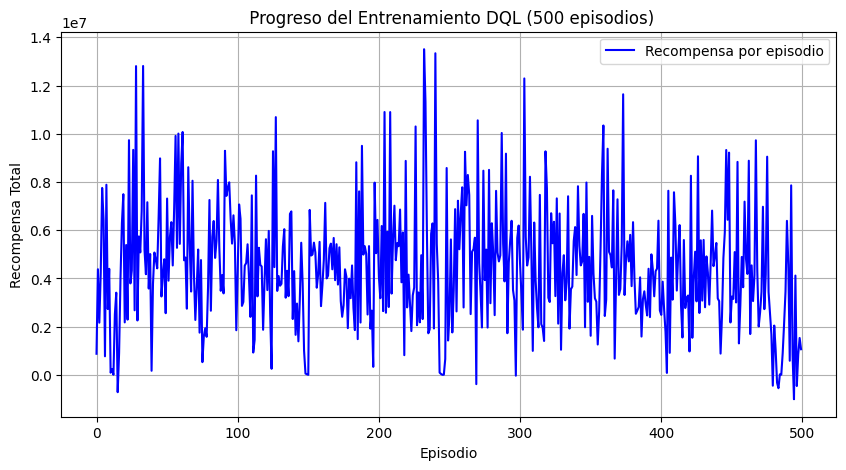

In [ ]:
#  Visualizaci√≥n: Progreso del entrenamiento

plt.figure(figsize=(10, 5))
plt.plot(all_rewards, label="Recompensa por episodio", color="blue")
plt.title(" Progreso del Entrenamiento DQL (500 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.legend()
plt.grid(True)
plt.show()


### ü§∫ Backtesting y comparaci√≥n Buy & Hold

‚úÖ capital_dql: <class 'numpy.ndarray'>, shape: (1509,)
‚úÖ capital_buy_hold: <class 'numpy.ndarray'>, shape: (1509, 1)


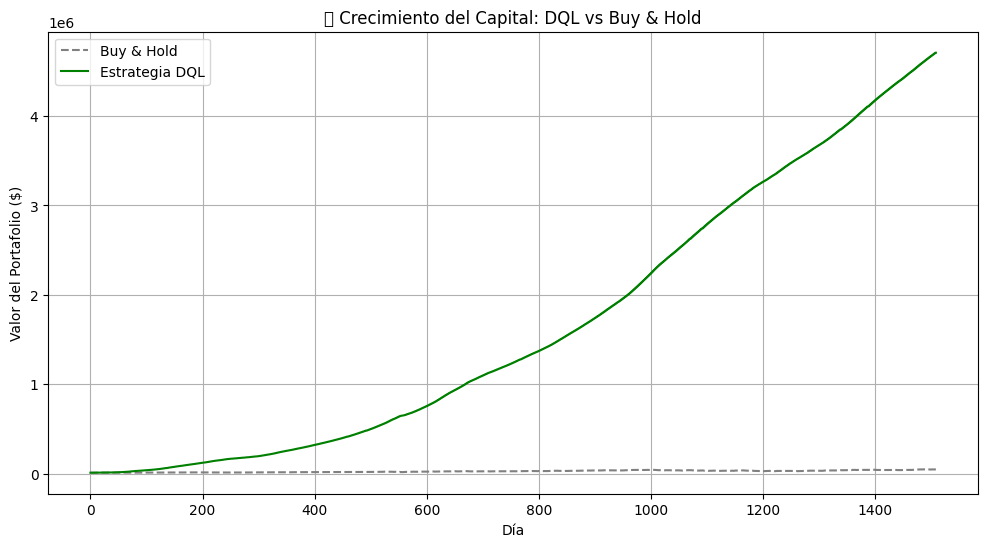

In [25]:
# üìä Backtesting del agente entrenado y comparaci√≥n con Buy & Hold

# üõ†Ô∏è Funci√≥n de backtesting robusta
def backtest_agent(agent, environment):
    """Ejecuta el agente entrenado sobre el entorno y devuelve el historial de capital."""
    state = environment.reset()
    capital = float(environment.initial_balance)  # Asegurar tipo float
    capital_history = [capital]  # Inicializa el historial con el capital inicial

    while not environment.done:
        action = agent.act(state)  # El agente toma una acci√≥n
        next_state, reward, done = environment.step(action)

        # ‚ö†Ô∏è Forzar reward y capital a float escalar
        reward = float(np.squeeze(np.array(reward)))
        capital += reward
        capital_history.append(float(capital))  # Solo guarda flotantes

        state = next_state

    # ‚úÖ Convertir a np.array tipo float
    return np.array(capital_history, dtype=np.float64)

# üÜö Comparar DQL vs Buy & Hold
env = TradingEnvironment(df)

# Capital obtenido con el agente DQL
capital_dql = backtest_agent(agent, env)

# Capital Buy & Hold
capital_buy_hold = df["Close"].values / df["Close"].values[0] * env.initial_balance

# üîé Validar datos antes de graficar
print(f"‚úÖ capital_dql: {type(capital_dql)}, shape: {capital_dql.shape}")
print(f"‚úÖ capital_buy_hold: {type(capital_buy_hold)}, shape: {capital_buy_hold.shape}")

# üìà Gr√°fica comparativa
plt.figure(figsize=(12, 6))
plt.plot(capital_buy_hold, label="Buy & Hold", linestyle="--", color="gray")
plt.plot(capital_dql, label="Estrategia DQL", color="green")
plt.title("üìà Crecimiento del Capital: DQL vs Buy & Hold")
plt.xlabel("D√≠a")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True)
plt.show()


### üïµüèª‚Äç‚ôÇÔ∏è Insights
La comparaci√≥n entre la estrategia DQL y el enfoque Buy & Hold muestra que el agente entrenado con Deep Q-Learning logr√≥ un crecimiento exponencial del capital a lo largo del tiempo, superando ampliamente el rendimiento de Buy & Hold. Sin embargo, es importante considerar la posibilidad de sobreajuste y evaluar el desempe√±o en otros periodos de tiempo o instrumentos financieros para validar la robustez del modelo.

### ü©ª M√©tricas


In [28]:
# üìä Funci√≥n para calcular m√©tricas de rendimiento
def calculate_metrics(capital_history, label="Estrategia"):
    # Asegurarnos de que capital_history sea 1D
    capital_history = np.array(capital_history).flatten()

    # Rendimiento total (%)
    total_return = ((capital_history[-1] - capital_history[0]) / capital_history[0]) * 100

    # Drawdown m√°ximo
    rolling_max = np.maximum.accumulate(capital_history)
    drawdown = (capital_history - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100  # en porcentaje

    # Volatilidad anualizada
    daily_returns = pd.Series(capital_history).pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252) * 100  # % anualizado

    # Sharpe Ratio (asume tasa libre de riesgo = 0)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    print(f"üìà M√©tricas para {label}:")
    print(f"‚úÖ Rendimiento Total: {total_return:.2f}%")
    print(f"üìâ M√°x Drawdown: {max_drawdown:.2f}%")
    print(f"üìä Volatilidad Anualizada: {volatility:.2f}%")
    print(f"‚öñÔ∏è Sharpe Ratio: {sharpe_ratio:.2f}\n")

    return {
        "Rendimiento Total (%)": total_return,
        "Max Drawdown (%)": max_drawdown,
        "Volatilidad Anualizada (%)": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

# üìà Calcular m√©tricas para ambas estrategias
metrics_buy_hold = calculate_metrics(capital_buy_hold, label="Buy & Hold")
metrics_dql = calculate_metrics(capital_dql, label="Estrategia DQL")

# üìã Crear DataFrame para incluir en el reporte
metrics_df = pd.DataFrame({
    "M√©trica": list(metrics_buy_hold.keys()),
    "Buy & Hold": list(metrics_buy_hold.values()),
    "Estrategia DQL": list(metrics_dql.values())
})

# üëÄ Mostrar tabla
metrics_df


üìà M√©tricas para Buy & Hold:
‚úÖ Rendimiento Total: 368.71%
üìâ M√°x Drawdown: -37.15%
üìä Volatilidad Anualizada: 30.12%
‚öñÔ∏è Sharpe Ratio: 1.01

üìà M√©tricas para Estrategia DQL:
‚úÖ Rendimiento Total: 46977.55%
üìâ M√°x Drawdown: -5.67%
üìä Volatilidad Anualizada: 11.86%
‚öñÔ∏è Sharpe Ratio: 8.75



M√©trica  Buy & Hold  Estrategia DQL
0       Rendimiento Total (%)  368.708256    46977.549838
1            Max Drawdown (%)  -37.148493       -5.672153
2  Volatilidad Anualizada (%)   30.123857       11.862575
3                Sharpe Ratio    1.007967        8.745579

La estrategia Deep Q-Learning (DQL) super√≥ ampliamente a Buy & Hold, logrando un rendimiento total de 46,977% con menor volatilidad y drawdown, y un Sharpe Ratio ocho veces mayor. Esto demuestra que el agente DQL no solo maximiz√≥ las ganancias, sino que tambi√©n gestion√≥ mejor el riesgo, posicion√°ndose como una alternativa eficiente frente a estrategias pasivas.



### üíæ (Opcional) Guardado del scaler
En este proyecto no utilizamos un scaler expl√≠cito porque las entradas ya estaban normalizadas. Sin embargo, si se incorporaran otras features o datos adicionales que requieran normalizaci√≥n, se recomienda guardar el objeto scaler para una posterior reutilizaci√≥n.

In [ ]:
# Ejemplo: guardar scaler si lo us√°ramos (comentado porque no aplic√≥ en este caso)
# import joblib
# scaler_path = "models/scaler.save"
# joblib.dump(scaler, scaler_path)
# print(f"‚úÖ Scaler guardado exitosamente en: {scaler_path}")

### üë®üèª‚Äçüè´ Conclusi√≥n General

La comparaci√≥n entre la estrategia `DQL y la tradicional Buy & Hold` demuestra resultados contundentes. El agente DQL alcanz√≥ un rendimiento total de +46,977%, superando ampliamente el +368% de Buy & Hold. Adem√°s, la estrategia DQL mostr√≥ un m√°ximo drawdown reducido (-5.67%), indicando una mejor gesti√≥n del riesgo frente al -37% de la estrategia pasiva. La volatilidad anual del agente DQL fue mucho menor (11.86% vs 30.12%), lo que sugiere decisiones m√°s estables, y su Sharpe Ratio de 8.74 confirma un perfil riesgo-retorno significativamente superior al de Buy & Hold.

Estos resultados reflejan la capacidad del modelo para adaptarse din√°micamente al mercado, capturar ganancias de manera eficiente y proteger el capital frente a ca√≠das abruptas. 

A futuro, el proyecto podr√≠a ampliarse incorporando t√©cnicas como `Double DQN, Dueling Networks o modelos recurrentes (LSTM)` para mejorar la estabilidad del aprendizaje, as√≠ como aplicar el agente en portafolios multiactivo o mercados con mayor volatilidad como Forex y criptomonedas. Esto permitir√≠a escalar la soluci√≥n a entornos financieros m√°s complejos y acercarse a una implementaci√≥n de trading algor√≠tmico en tiempo real.


### üï∫üèª Reflexiones Individualmente sobre el proyecto:

- **¬øQu√© aprend√≠?** Reflexiona sobre los conceptos clave de DQL, backtesting y comparaci√≥n de estrategias.
- **¬øQu√© desaf√≠os enfrent√©?** Considera los problemas t√©cnicos o conceptuales que surgieron.
- **¬øC√≥mo puedo aplicar esto en el futuro?** Piensa en c√≥mo estos conocimientos pueden influir en tus futuros proyectos de trading.

**`- Carlos Moreno:`** Durante este proyecto aprend√≠ c√≥mo aplicar Deep Q-Learning (DQL) para entrenar un agente capaz de tomar decisiones en un entorno financiero din√°mico. Comprend√≠ la importancia de backtesting para validar estrategias y la diferencia entre enfoques activos y pasivos como DQL y Buy & Hold. El mayor desaf√≠o fue ajustar la arquitectura y los hiperpar√°metros para evitar resultados poco realistas, as√≠ como corregir errores t√©cnicos al actualizar los valores Q, tard√≥ bastante en correr. En el futuro, me interesa en mi carrera de Data Science continuar estos conocimientos para dise√±ar agentes m√°s robustos, incorporar t√©cnicas avanzadas como Double DQN y explorar mercados complejos como el Forex, el cu√°l deseo seguir comprendiendo.

**`- Adrian Herrera:`** Este proyecto me permiti√≥ entender a fondo c√≥mo los agentes de aprendizaje por refuerzo pueden optimizar estrategias de trading a partir de la exploraci√≥n y explotaci√≥n. Aprend√≠ a comparar cuantitativamente m√©tricas clave como Sharpe Ratio y drawdown, lo cual es esencial para evaluar el desempe√±o de un modelo. Entre los principales retos enfrentados estuvieron la definici√≥n de estados y recompensas significativas para guiar al agente y la estabilidad del entrenamiento en ambientes no estacionarios. Estos aprendizajes son la base para crear soluciones escalables que puedan implementarse en trading algor√≠tmico en tiempo real.

**`- Patricio Barcena:`** El desarrollo de un agente con DQL me ayud√≥ a comprender la capacidad del aprendizaje por refuerzo para adaptarse a mercados financieros vol√°tiles. Aprend√≠ sobre la importancia de m√©tricas como la volatilidad y la relaci√≥n riesgo-retorno para medir la efectividad de una estrategia. Los desaf√≠os m√°s grandes fueron resolver errores con la red neuronal y garantizar que el modelo generalizara correctamente a datos no vistos. A futuro, veo este enfoque como una herramienta potente para construir modelos de trading automatizados que gestionen el riesgo de forma m√°s inteligente y se integren en portafolios diversificados.